### Import packages

In [1]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

### Set all important file paths

In [2]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [259]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'



In [3]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"



### Create some test documents

In [4]:
doc_a = "Brocolli is good to eat. My brother likes to eat good brocolli, but not my mother."
doc_b = "My mother spends a lot of time driving my brother around to baseball practice."
doc_c = "Some health experts suggest that driving may cause increased tension and blood pressure."
doc_d = "I often feel pressure to perform well at school, but my mother never seems to drive my brother to do better."
doc_e = "Health professionals say that brocolli is good for your health."
doc_set = [doc_a, doc_b, doc_c, doc_d, doc_e]

test_string = ('Okay? Thanks, Don! Next-slide is a 493 little bit of detail on the significant charges, with the Pizza'
               ' Sprint and German acquisitions. As you can see, we\'ve got the split now between Pizza Sprint'
               ' and Germany.')
test_string2 = 'If not staying at the XXXX please note that East Malvern footy club is right at Darling station (see' \
               ' train line map below). To make it easy for yourself to get around by train it is recommended that you' \
               ' stay somewhere close to a train station that is on the Glen Waverley train line' \
               ' (the full train line is shown below). From there you will be able to easily get to and from,' \
               ' East Malvern Knights Footy Club (Darling station), Etihad (Southern Cross station) and the MCG' \
               ' (Richmond or Parliament stations).'
test_string3 = "It's your toy, not Richard's."
test_strings = [test_string, test_string2, test_string3]


### Import a dictionary

Import a bag of words style dictionary for word counting analyses


In [5]:
def get_dictionary(file_path, file_name):
    """Read a standard word list dictionary text file into a list"""
    with open(file_path + file_name, "r") as file:
#         words = [word.lower().rstrip('\n') for word in file]
        words = [word.lower().rstrip() for word in file] # had to strip \r as well on my machine
    return words


#### Example

In [6]:
function_words = get_dictionary(LIBRARY_PATH,'function_words.txt')

In [7]:
print (function_words[:10])

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


### Function to collect file paths

In [8]:
# Get the file paths to all files of a specified file type from a given directory
def get_files(file_path, file_type):
    file_list = glob.glob(file_path + "*." + file_type)
    return file_list

TextFiles = []
# Read in all the file paths from subdirectories into a master list
for d in ["T1", "T2", "T3", "T4"]:
    TextFiles.extend(get_files(LIBRARY_PATH+d+"/",'txt'))

# Print first 5 files as an example
TextFiles[:5]

['/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_AEP.txt',
 '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_CVX.txt',
 '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_MET.txt',
 '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_MRK.txt',
 '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_SPG.txt']

### Check files have the correct identifier

In [9]:
def quick_read_transcript(file_path):
    # read in all lines of the transcript
    file_code = file_path.split('_')[-1][:-4]
    
    i = 0
    results = []

    with open(file_path, "r") as file:
        while i < 4:
            try:
                results.append(file.readline().rstrip()) # remove new line and any surrounding spaces
                i += 1
            except UnicodeDecodeError:
                results = ["UnicodeDecodeError in file"]
                i = 4
    try:
        code = results[1].split(': ')[1].split(' ')[0]
    except:
        code = result[1]
    try:
        event = results[3].split(': ')[1]
    except:
        event = results[3]
    return (file_code, code, event)
    
quick_read_transcript(TextFiles[0])   

('AEP', 'AEP', 'Q2 2010 Earnings Call')

In [10]:
i = 0
for tf in sorted(TextFiles):
    result = quick_read_transcript(tf)
    if result[0] != result[1]:
#         print (tf.split('Text\\')[1], result)
        print (tf, result)
    i += 1

('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101027_1_0848680D.txt', ('0848680D', 'S', 'Q3 2010 Earnings Call'))
('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110428_1_0848680D.txt', ('0848680D', 'S', 'Q1 2011 Earnings Call'))
('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110714_1_GOOGL.txt', ('GOOGL', 'GOOG', 'Q2 2011 Earnings Call'))
('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110728_1_0848680D.txt', ('0848680D', 'S', 'Q2 2011 Earnings Call'))
('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20111013_1_GOOGL.txt', ('GOOGL', 'GOOG', 'Q3 2011 Earnings Call'))
('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20111026_1_0848680D.txt', ('0848680D', 'S', 'Q3 2011 Earnings Call'))
('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120119_1_GOOGL.txt', ('GOOGL', 'GOOG', 'Q4 2011 Earnings Call'))
('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120208_1_0848680D.txt', ('0848680D', 

GOOGL shows up as GOOG and GOOGL in the returns_data.  Sprint is symbol 'S' but shows up as 0848680D in the returns data.  So both will match correctly.

### Check which are not Earnings Call's

In [11]:
i = 0
for tf in sorted(TextFiles):
    result = quick_read_transcript(tf)
    if result[2].find('Earnings Call') == -1:
#         print (tf.split('Text\\')[1], result)
        print (tf, result)
    i += 1


('/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101019_1_AEP.txt', ('AEP', 'AEP', 'Analyst Day'))


Just one is not an Earnings Call, so remove

### Determine if we are missing any calls

In [12]:
# Create a set of all possible calls in our lookback window
calls_full_set = []
for year in range(2010,2019):
    for quarter in range(1,5):
        calls_full_set.append(str(year) + '_' + str(quarter))
print (calls_full_set)

['2010_1', '2010_2', '2010_3', '2010_4', '2011_1', '2011_2', '2011_3', '2011_4', '2012_1', '2012_2', '2012_3', '2012_4', '2013_1', '2013_2', '2013_3', '2013_4', '2014_1', '2014_2', '2014_3', '2014_4', '2015_1', '2015_2', '2015_3', '2015_4', '2016_1', '2016_2', '2016_3', '2016_4', '2017_1', '2017_2', '2017_3', '2017_4', '2018_1', '2018_2', '2018_3', '2018_4']


In [13]:
# Script to reorganise event description
def tidy_call_text(text):
    text = text.split(' ')
    call = text[1] + '_' + text[0][-1:]
    return call

# Script to see if there are any events missing between the first and last recorded events 
def find_missing(stock_list, full_list):
    first_q = stock_list[0]
    last_q = stock_list[-1]
    start = full_list.index(first_q)
    end = full_list.index(last_q) + 1
    adj_full_list = full_list[start:end]
    missing = []
    for q in adj_full_list:
        if q not in stock_list:
            missing.append(q)
    return missing

# Script to see if there are any events that are duplicates 
def duplicate_calls(call_list):
    duplicates = []
    counts = {call: call_list.count(call) for call in call_list}
    duplicates = [key for key, value in counts.items() if value > 1]
    return duplicates

In [14]:
 
all_calls ={}

for tf in sorted(TextFiles):
    result = quick_read_transcript(tf)
    if result[2].find('Earnings Call') != -1 and result[2].find('Fixed') == -1:   # Found an earnings call
        ticker = result[1]
        tidy_call = tidy_call_text(result[2])
        if result[1] not in all_calls.keys():
            all_calls[ticker] = [tidy_call]
        else:
            all_calls[ticker].append(tidy_call)

for ticker in sorted(all_calls.keys()):
    print (ticker, sorted(all_calls[ticker]))
            



('AA', ['2016_4', '2017_1', '2017_2'])
('AAPL', ['2010_4', '2011_1', '2011_2', '2011_3', '2011_4', '2012_1', '2012_2', '2012_3', '2012_4', '2013_1', '2013_2', '2013_3', '2013_4', '2014_1', '2014_2', '2014_3', '2014_4', '2015_1', '2015_2', '2015_3', '2015_4', '2016_1', '2016_2', '2016_3', '2016_4', '2017_1', '2017_2', '2017_3'])
('ABBV', ['2013_1', '2013_2', '2013_3', '2013_4', '2014_1', '2014_2', '2014_3', '2014_4', '2015_1', '2015_2', '2015_3', '2015_4', '2016_1', '2016_2', '2016_3', '2016_4', '2017_1', '2017_2'])
('ABT', ['2010_3', '2010_4', '2011_1', '2011_2', '2011_3', '2011_4', '2012_1', '2012_2', '2012_3', '2012_4', '2013_1', '2013_2', '2013_3', '2013_4', '2014_1', '2014_2', '2014_3', '2014_4', '2015_1', '2015_2', '2015_3', '2015_4', '2016_1', '2016_2', '2016_3', '2016_4', '2017_1', '2017_2'])
('ACN', ['2010_4', '2011_1', '2011_2', '2011_3', '2011_4', '2012_1', '2012_2', '2012_3', '2012_4', '2013_1', '2013_2', '2013_3', '2013_4', '2014_1', '2014_2', '2014_3', '2014_4', '2015_1', 

### Missing calls?¶

In [15]:
for ticker in sorted(all_calls.keys()):
    missing = find_missing(all_calls[ticker],calls_full_set)
    if len(missing) > 0:
        #print (ticker, 'includes:', all_calls[ticker])
        print (ticker, 'missing:', missing)
        print ()

('AEP', 'missing:', ['2010_3', '2011_4', '2012_4', '2016_3'])
()
('AGN', 'missing:', ['2013_4', '2014_4'])
()
('BHI', 'missing:', ['2015_1', '2015_2', '2015_3', '2015_4', '2016_1'])
()
('COF', 'missing:', ['2011_2'])
()
('ETR', 'missing:', ['2011_1'])
()
('EXC', 'missing:', ['2012_1', '2016_2'])
()
('F', 'missing:', ['2012_1', '2012_2', '2012_3', '2013_1', '2013_2', '2013_3', '2013_4', '2014_2', '2014_3', '2015_1', '2015_2', '2015_3', '2015_4'])
()
('GOOGL', 'missing:', ['2011_2', '2011_3', '2011_4', '2012_1', '2012_2', '2012_3', '2012_4', '2013_1', '2013_2'])
()
('LOW', 'missing:', ['2015_1', '2015_2', '2015_4'])
()
('MDLZ', 'missing:', ['2011_4'])
()
('NKE', 'missing:', ['2011_4'])
()
('SO', 'missing:', ['2016_3'])
()
('TGT', 'missing:', ['2016_4'])
()


Note:
    
- **GOOGL** are not missing just have an incorrect code in the text file

- **LOW** are not missing just have a year typo in the file

- **F** have 'Fixed' in their event description

Otherwise about 30 odd missing ore around 1%.



### Duplicate calls?¶

In [16]:
dup_2012_4 = []

for ticker in sorted(all_calls.keys()):
    duplicates = duplicate_calls(all_calls[ticker])
    if len(duplicates) > 0:
        if len([i for i in duplicates if i != '2012_4']) > 0:
            print (ticker, 'duplicates:', [i for i in duplicates if i != '2012_4'])
        if '2012_4' in duplicates:
            dup_2012_4.append(ticker)

print ()
print ('2012_4', dup_2012_4)



('HNZ', 'duplicates:', ['2014_2', '2014_1'])
('LOW', 'duplicates:', ['2016_1', '2016_2', '2016_4'])
('UTX', 'duplicates:', ['2014_4'])
('WMB', 'duplicates:', ['2016_4'])
()
('2012_4', ['AIG', 'AMZN', 'BAC', 'C', 'CAT', 'CMCSA', 'DIS', 'DOW', 'DVN', 'FB', 'FOXA', 'GE', 'GS', 'HAL', 'HPQ', 'IBM', 'INTC', 'KO', 'MCD', 'NOV', 'ORCL', 'QCOM', 'SLB', 'T', 'UTX', 'VZ', 'WMT'])


Seems Heinz may have changed year end. A favorite they had a fifth quarter in 2014 see 20140320_1_HNZ.txt

Also for LOW there is a typo of the year in their duplicates, so they also have an equivalent missing.

There was also a problem with a number of the 2012_4 files which were reproduced, so need to be back dated.

### Get unique stock identifiers from the PDF file names collected from Bloomberg

Check to see that we have both transcripts and returns for all the stocks in our universe. 

In [11]:
# # Collect unique codes
# unique_codes = []
# for i in PDFFiles:
#     code = i.split('_')[1]
#     if code not in unique_codes:
#         unique_codes.append(code.upper())

# print (sorted(unique_codes))
# print (len(unique_codes))    

#### Comment

There have been 126 codes in the S&P 100 over our back-test window. We don't have transcripts for the following four codes and the reasons why are:

- **BRK/B:** This is the ticker in the S&P 100. Maybe the transcripts are under BRK/A.
- **FOX:** This is a duplicate of FOXA, i.e. there are two share categories, so there is only one transcript across both.
- **DWDP:** There was merger between DOW and Dupont just before the end of our back-test window, so there is not a transcript for the new merger company in our universe.
- **GOOG:** This is a duplicate of GOOGL, i.e. there are two share categories, so there is only one transcript across both.

So really only BRK/B. This won't make or break our analysis.

# Exploratory Analysis

### Check the transcript list indices for each of the major sections of the calls

This section is designed check how well we can parse the transcripts into each of the major sections allowing for differences in the possible headers used.

In [17]:
# Different possible section headers
CO_PART_HEADERS = ['Company Participants']
OTH_PART_HEADERS = ['Other Participants']
MD_SECTION_HEADERS = ['MANAGEMENT DISCUSSION SECTION', 'Presentation']
QA_SECTION_HEADERS = ['Q&A', 'Questions And Answers', 'QUESTION AND ANSWER SECTION',
                      'QUESTION AND ANSWER SESSION', 'QUESTION-AND-ANSWER SECTION']
DISCLAIMER = ['This transcript may not be 100 percent accurate ']


In [18]:

# New text file format has headers
def remove_header_footers(ts):
    i = 0
    header_footer = []
    # Add all the lines before the first 'Page 1 of n' line
    while ts[i].find('Page') == -1:
#         if ts[i].find('Fixed') != -1:
#             print (ts[1], ts[2])
        header_footer.append(ts[i])
        i += 1
    # Extract the total page number and add lines to strip for all the 
    # 'Page x of n' line
    pages = ts[i]
    pages = pages.split(' ')
    page_num = int(pages[-1])
    for i in range(1, page_num + 1):
        header_footer.append('Page ' + str(i) + ' of ' + str(page_num))
    ts = [line for line in ts if line not in header_footer]
    return ts


def read_transcript(file_path):
    # read in all lines of the transcript
    with open(file_path, "r") as file:
        ts = file.readlines()
        ts = [str(unicode(line, errors = 'ignore')) for line in ts]
        ts = [line.rstrip() for line in ts]
        ts = remove_header_footers(ts)
    return ts


# Find the index value of a full string from a list of possible strings
def find_full_string_index(ts, string_list):
    result = -1
    for i in range(len(string_list)):
        if string_list[i] in ts:
            result = ts.index(string_list[i])
    return result

# Find the index of the disclaimer
def find_disclaimer_index(ts, string_list):
    result = -1
    k = len(ts) - 1
    while True:
        for my_str in string_list:
            if ts[k].find(my_str) != -1:
                result = k
                break
        k -= 1
        if k < 0:
            break
    return result

# Get transcript list indices from a single transcript
def get_basic_parameters(ts):
    call_type = ts[0]
    # check call type
    if call_type.find("Earnings Call") == -1:
        call_type = -1
    else:
        if call_type.find("Fixed") != -1:  # don't want Fixed Income calls
            call_type = -1
            
    co_parts = find_full_string_index(ts,CO_PART_HEADERS)
    oth_parts = find_full_string_index(ts,OTH_PART_HEADERS)
    md = find_full_string_index(ts,MD_SECTION_HEADERS)
    qa = find_full_string_index(ts,QA_SECTION_HEADERS)
    disc = find_disclaimer_index(ts,DISCLAIMER)
    return [call_type, co_parts, oth_parts, md, qa, disc]


In [19]:
# Print results that have a -1 in the index parameters
# Broken up by Q&A problem or other problem
no_QA = []
print 'Problems other than missing Q&A:'
for path in TextFiles:
    ts = read_transcript(path)
    params = get_basic_parameters(ts)
    # Check if Q&A problem
    if params[2] == -1 or params[4] == -1:
        no_QA.append((path, params)) 
    # Check if other problem
    if params[1] == -1 or params[3] == -1 or params[5] == -1:
        print (path, params)

print ()
print ('Calls with Q&A problem:')
i = 0
for call in no_QA:
    if call[1][2] == -1 and call[1][4] == -1:
        print ('No Q&A:', call[0])
    else:
        print ('Other Q&A problem:', call[0], call[1])
        i += 1
print ()
print ('Total calls with no Q&A:', len(no_QA) - i)
print ('Total calls with Q&A problems other than no Q&A:', i)

Problems other than missing Q&A:
()
Calls with Q&A problem:
('No Q&A:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100806_1_AIG.txt')
('No Q&A:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100817_1_WMT.txt')
('Other Q&A problem:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101019_1_AEP.txt', [-1, 1, -1, 12, 1198, 1522])
('No Q&A:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101105_1_AIG.txt')
('No Q&A:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101110_1_GM.txt')
('No Q&A:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101116_1_WMT.txt')
('No Q&A:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110517_1_WMT.txt')
('Other Q&A problem:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110728_1_AXP.txt', [-1, 1, -1, 5, 240, 253])
('No Q&A:', '/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110816_1_WMT.txt')
('No Q&A:', '/Users/seddont/Dropbox/

### Comment
Main problems are:

(1) Sometime there is no Q&A section in a call. This can be commonly identified because no index can be found for both `Other Participants` and the `Q&A` section.

(2) Some of the second files appear to be GAAP presentations.

(3) Probably also just want the Earnings Calls only, i.e. exclude Analyst Day, Fixed Income, Pre-recorded, etc.?

In original data, found 3 files which showed up as having a Q&A problem that weren't Analyst Day or Fixed Income:
2013_0724_1_LLY  - Q&A section but no header -- added it by hand in correct location  
20170620_1_FDX   - no 'other participants' list, but is a Q&A section  
20170919_1_FDX   - no 'other participants' list, but is a Q&A section  


## Build a list of files that have valid Q&A sections we want to use

In [56]:
# Get the file paths to all files of a specified file type from a given directory
def get_files(file_path, file_type):
    file_list = glob.glob(file_path + "*." + file_type)
    return file_list

def get_files_from_dirs(directory_list, file_type):
    # Read in all the files from subdirectories into a master list
    
    matchfiles = []
    for d in directory_list:
        matchfiles.extend(get_files(LIBRARY_PATH+d+"/",'txt'))    
    return matchfiles

def find_valid_files(file_list):
    '''Scans all the files in the file list and returns a list of those which
       pass all QA checks, and a list of those that do not, with reason why'''
    
    good_files = []
    problems = []

    for path in file_list:
        ts = read_transcript(path)
        params = get_basic_parameters(ts)
        
        errs = ["not equity earnings call",
                "no co participants",
                "no other participants",
                "no mgmt discussion section",
                "no Q&A section",
                "no disclaimer"
                ]
        
        errs_found = []
        for i, err in enumerate(errs):
            if params[i] == -1:
                errs_found.append(err)
        
        if len(errs_found) == 0:
            good_files.append(path)
        else:
            problems.append((errs_found, path, params))

    return good_files, problems


files_to_check = get_files_from_dirs(TEXT_DIR_LIST, "txt")
TextFiles, error_files = find_valid_files(files_to_check)

print "Valid Files found: ", len(TextFiles)
print
print "Files rejected:", len(error_files)
print
err_counts = defaultdict(int)
err_lists = defaultdict(list)
for f in error_files:
    for err in f[0]:
        err_counts[err] += 1
        err_lists[err].append(f[1])

print "Number of files with each type of error (file can have >1 error):"
for err in err_counts:
    print err, err_counts[err]
    print "Files are:"
    for f in err_lists[err]:
        print f
   



Valid Files found:  3245

Files rejected: 103

Number of files with each type of error (file can have >1 error):
no Q&A section 42
Files are:
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100806_1_AIG.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100817_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101105_1_AIG.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101110_1_GM.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101116_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110517_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110816_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20111115_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120221_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120517_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120816_1_WMT.txt
/Users/seddo

### Store a transcript for testing

In [21]:
# Store a test transcript
i = 2
ts = read_transcript(TextFiles[i])
TextFiles[i]


'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100730_1_MET.txt'

In [22]:
ts

['Q2 2010 Earnings Call',
 'Company Participants',
 ' Conor Murphy, Investor Relations',
 ' C. Robert Henrikson, Chairman, President and Chief Executive Officer',
 ' Steven A. Kandarian, Executive Vice President and Chief Investment Officer',
 ' William J. Wheeler, Executive Vice President and Chief Financial Officer',
 ' William Mullaney',
 ' William Toppeta',
 ' Peter Carlson',
 'Other Participants',
 ' Mark Finkelstein',
 ' John Hall',
 ' Colin Devine',
 ' Jimmy Bhullar',
 ' John Nadel',
 ' Suneet Kamath',
 ' Andrew Kligerman',
 ' Randy Binner',
 'MANAGEMENT DISCUSSION SECTION',
 'Operator',
 'Ladies and gentlemen, thank you for standing by. Welcome to the MetLife second quarter earnings release conference',
 'call. [Operator Instructions] As a reminder, this conference is being recorded.',
 'Before we get started, I would like to read the following statement on behalf of MetLife.',
 'Except with respect to historical information, statements made in this conference call can constitu

### Check for items that need to be excluded from the strings because they are housed in square brackets '[]'

It is notable that some text that is not spoken is included in the transcripts between square brackets '[]', so this should ideally be removed as part of pre-processing.

The following lines in the test transcript feature square brackets:

In [23]:
# find examples with squares brackets
[line for line in ts if '[' in line]


['call. [Operator Instructions] As a reminder, this conference is being recorded.',
 '[Operator Instructions] We have our first question from the line of Mark Finkelstein with Macquarie. Please go ahead,',
 'the situation, including the National Organization of [Health and] Life Guaranty Association [NOHLGA], the NAIC,',
 '[Laughter]',
 '[Accumulated Other Comprehensive Income] and the movements there and also, net income versus operating income.']

We can use regex to strip out these occurrences:

In [24]:
# Use regex to replace characters in between and including square brackets
[re.sub(r'\[.+?\]', '', line) for line in ts if '[' in line]

# Note that the above makes no allowance for spaces on either side of the square brackets
# The following makes some allowance, but seems to be hard to allow for all possibilities neatly
#[re.sub(r'\[.+?\]\s*', '', re.sub(r'\[.+?\]\.\s*', '', i)) for i in a]

['call.  As a reminder, this conference is being recorded.',
 ' We have our first question from the line of Mark Finkelstein with Macquarie. Please go ahead,',
 'the situation, including the National Organization of  Life Guaranty Association , the NAIC,',
 '',
 ' and the movements there and also, net income versus operating income.']

### Pre-process function to remove contents of square brackets

Use the above as a pre-processing function:

In [25]:
def remove_square_brackets(my_str):
    return re.sub(r'\[.+?\]', '', my_str)

def remove_square_brackets_transcript(ts):
    return list(map(lambda line: remove_square_brackets(line), ts))


Confirm that all occurrences have been removed

In [26]:
ts_test = remove_square_brackets_transcript(ts)
[re.sub(r'\[.+?\]', '', line) for line in ts_test if '[' in line]

[]

### Get Company Participants

Sometimes the names are used with their title, without their title and without their middle initial. Using the indices for the `Company Participants` and `Other Participants` section the `get_parts` function retrieves the participants from the Company Participants section and creates a set of all these possible name combinations.

**Note:** We possibly don't need the names because we are more interested in aggregate evasiveness, but some papers show that different roled people can behave with systematically different behaviour, so could be something we test if time permits.


In [27]:
# Find participants on the call
def get_parts(ts, start_index, end_index):
    result = [name[re.search("[a-z]", name.lower()).start():] for name in ts[start_index+1:end_index] if len(name) >= 3]
    # Check for problematic names
    extra_names = []
    for name in result:
        # Find any title after name and remove it
        if name.find(',') != -1:
            name_only = name[:name.find(',')]
            extra_names.append(name_only)
        # Find names with middle initials and remove them
        elif name.find('.') != -1:
            name_only = remove_middle_initials(name)
            if name_only != name:
                extra_names.append(name_only)
    # Find names in extra names with middle initials and remove them
    for name in extra_names:
        if name.find('.') != -1:
            name_only = remove_middle_initials(name)
            if name_only != name:
                extra_names.append(name_only)
    return result + extra_names

# Remove middle initial from a name
def remove_middle_initials(my_str):
    # count = 0
    while True:
        if my_str.find('.') != -1:
            new_my_str = re.sub(r'(\s)([A-Z].)(\s)', r"\1", my_str)
            if new_my_str == my_str:
                break
            else:
                my_str = new_my_str
            # count += 1
            # if count >= 10:
            #     break
        else:
            break
    return my_str


In [28]:
# Get Company Participants
start = find_full_string_index(ts,CO_PART_HEADERS)
end = find_full_string_index(ts,OTH_PART_HEADERS) - 1
co_part_names = get_parts(ts, start, end)
co_part_names

['Conor Murphy, Investor Relations',
 'C. Robert Henrikson, Chairman, President and Chief Executive Officer',
 'Steven A. Kandarian, Executive Vice President and Chief Investment Officer',
 'William J. Wheeler, Executive Vice President and Chief Financial Officer',
 'William Mullaney',
 'William Toppeta',
 'Conor Murphy',
 'C. Robert Henrikson',
 'Steven A. Kandarian',
 'William J. Wheeler',
 'Steven Kandarian',
 'William Wheeler']

**Comment:** This appears to be working quite well.

### Get Other Participants

Other Participants tend to be identified by name only, but if any titles or middle initials are used the `get_parts` function will take the participants from the Other Participants section and creates a set of all these possible name combinations.

**Note:** It is unlikely that we will need individual analyst names because we are interested in management evasiveness.


In [29]:
# Get Other Participants
start = find_full_string_index(ts, OTH_PART_HEADERS)
end = find_full_string_index(ts, MD_SECTION_HEADERS) - 1
oth_part_names = get_parts(ts, start, end)
oth_part_names


['Mark Finkelstein',
 'John Hall',
 'Colin Devine',
 'Jimmy Bhullar',
 'John Nadel',
 'Suneet Kamath',
 'Andrew Kligerman']

**Comment:** This appears to be working quite well.

### Get an indexed section of the call

In [30]:
# Find a section of the call
def get_section(ts, start_index, end_index):
    result = ts[start_index+1:end_index]
    result = [line for line in result if line not in ['\x0c']]   # clean the transcript for unnecessary lines
    return result


### Get MD Section


In [31]:
def get_MD(ts, names, start_index, end_index):

    curr_speaker = ""
    section_header = "MD"
    
    # Create an empty dict for comments by each manager
    pts = {name: "" for name in names}

    # Get the required section
    section = get_section(ts, start_index, end_index)
    
    # Find the first instance of a co_parts speaker
    start_section = 0
    while True:
        if section[start_section] not in names:
            start_section += 1
        else:
            break
        if start_section == len(section):
            start_section = -1
            break

    if start_section == -1:
        pts['No speaker found'] = section_header
    else:
        # Reduce MD Section to management speaking only
        section = section[start_section:]
        # populate comment dict
        for line in section:
            if line in names:
                curr_speaker = line
            elif len(line) != 0:
                pts[curr_speaker] += line + " "

    return pts


In [32]:
# Get MD Section
start = find_full_string_index(ts,MD_SECTION_HEADERS)
end = find_full_string_index(ts,QA_SECTION_HEADERS) - 1
get_MD(ts, co_part_names, start, end)

{'C. Robert Henrikson': '',
 'C. Robert Henrikson, Chairman, President and Chief Executive Officer': "Thank you, Conor, and good morning, everyone. For the second quarter of 2010, MetLife has again delivered strong results across the board. Remember, last December at Investor Day we highlighted our commitment to disciplined growth, margin improvement and ROE expansion. While we delivered on that commitment in the first quarter and I believe we have done so yet again in the second, our premiums, fees, and other revenues increased 4% over the second quarter of 2009. Operating earnings grew to over 1 billion, up considerably from both the year-ago period and sequentially. I'm also pleased to report that book value increased tremendously, up 48% over the year-ago period and 10% sequentially, driven not only by our investment performance, but also our strong operating earnings. At the same time, our ROE continued to improve and we achieved excellent underwriting results. And importantly, we

### QA Section


#### Raw review of the QA Section

In [33]:
start = find_full_string_index(ts, QA_SECTION_HEADERS)
end = find_disclaimer_index(ts,DISCLAIMER)
get_section(ts, start, end)

['Operator',
 '[Operator Instructions] We have our first question from the line of Mark Finkelstein with Macquarie. Please go ahead,',
 'your line is open.',
 "<Q - Mark Finkelstein>: Good morning, hopefully you can hear me okay. There's a lot of static. I guess it was a good",
 'quarter. You had favorable mortality, good morbidity, good investment results, good expense control across the board.',
 "I think if you looked at a core number, it's somewhere in the 1.10 to 1.15 range. I guess what I'm really interested in is",
 'how should we think about this level of earnings and whether we should be trending off this number or whether we',
 'should be thinking about a little bit lower number just given the level of favorability in the quarter.',
 "<A - William J. Wheeler, Executive Vice President and Chief Financial Officer>: Hi, Mark, it's Bill. Yes, we did",
 "hear your question. I always hesitate say whether $1.11 is a good run rate or not, but I'll give you some sense of the",
 'pluse

#### Get Questions with their matching Answers (with no consideration of who the respondent is)

This will be useful for the topic modelling part to determine whether the answer is on topic with the question.

Some considerations allowed for:

- Some of the strings in the transcript are NULL's, i.e. `''`, so these are ignored

- The Operator makes comments after a line that is solely `'Operator'`. Any comments after such a line are ignored until a question is found.

> For example, in the following portion of a call we want to ignore the Question by Doug Legatte that is a concluding statement and the comments by the Operator. The current code acheives this:

> `
 '<Q - Doug Leggate>: Okay, Pat. Would you give us a run rate perhaps for the underlying tax rate?',
 '',
 '<A - Patricia E. Yarrington, Chief Financial Officer & Vice President>: I think the best way to look at it is, over a',
 "long period of time, we've been a little bit lower this year than we were in 2009. So maybe on average for 2010 we may",
 "be a little bit lower. But it's not an area I want to get into predicting.",
 '',
 '<Q - Doug Leggate>: All right. Thanks for answering my questions. Thanks.',
 '',
 'Operator',
 '',
 'Our next question comes from Evan Calio with Morgan Stanley. Please go ahead.',
 '',
 '<Q - Evan Calio>: Good morning, everybody.',
`

- Some strings commmence with `'<Q'` or `'<A'`, but have no participant associated with them, so the next character in the string is `'>'`, whilst others have an associated participant designated by the next 3 characters being `' - '` before their name then `'>'`.







In [34]:
# This procedure combines the raw Q&A section into pairs of questions and answers in a dictionary

def get_QA(ts, start_index, end_index):

    pts = {}
    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    q_or_a = None
    currQ = ''
    currA = ''
    
    for line in qa_section:
        line = remove_square_brackets(line)
        if len(line) > 0:                                     # if line is '' then ignore otherwise process the line
            if line == 'Operator':                            # if line is 'Operator' then set everything NULL and ignore
                q_or_a = None
                currQ = ''
                currA = ''
            if line[0] == "<":                                # if Q or A found do something
                if line[0:2] == "<Q":
                    if q_or_a == 'A':                         # if Q found and q_or_a is not NULL then add Q: A to the dictionary
                        pts[currQ[:-1]] = currA[:-1]          # and reset the parameters to NULL
                        currQ = ''
                        currA = ''
                        q_or_a = None    
                    end_qa_tag = line.find(">")
                    currQ += line[end_qa_tag + 3:] + " "      # Concatenate the string after the '>' to the previous string
                    q_or_a = 'Q'                              # Given Q found set q_or_a = 'Q'
                if line[0:2] == "<A":
                    end_qa_tag = line.find(">")             
                    currA += line[end_qa_tag + 3:] + " "      # Concatenate the string after the '>' to the previous string
                    q_or_a = 'A'                              # Given Q found set q_or_a = 'Q'
            else:                                             
                if q_or_a is not None:                        # Other if currently a Q or A just concatenate the string 
                    if q_or_a == 'Q':
                        currQ += line + " "
                    else:
                        currA += line + " "

    if currQ != '' and currA != '':                           # Add last Q: A pair to the dictionary if necessary
        pts[currQ[:-1]] = currA[:-1]

    return pts




In [35]:
start = find_full_string_index(ts, QA_SECTION_HEADERS)
end = find_disclaimer_index(ts,DISCLAIMER)
get_QA(ts, start, end)

{'Good morning, everyone.': 'Good morning, John.',
 "Good morning, hopefully you can hear me okay. There's a lot of static. I guess it was a good quarter. You had favorable mortality, good morbidity, good investment results, good expense control across the board. I think if you looked at a core number, it's somewhere in the 1.10 to 1.15 range. I guess what I'm really interested in is how should we think about this level of earnings and whether we should be trending off this number or whether we should be thinking about a little bit lower number just given the level of favorability in the quarter.": "Hi, Mark, it's Bill. Yes, we did hear your question. I always hesitate say whether $1.11 is a good run rate or not, but I'll give you some sense of the pluses and minuses. You're right, underwriting was very strong, and so I think a lot of that is sustainable. Some of it was probably just good fortune. But I also think, by the way, like the improvements in dental underwriting margin are ver

#### Check if 'Operator' has been successfully removed from the questions in the Q&A section

In [36]:
# This should return an empty set if no mention of 'Operator'
[k for k in get_QA(ts, start, end).keys() if 'Operator' in k]


[]

#### Check if 'Operator' has been successfully removed from the answers in the Q&A section

In [37]:
[v for v in get_QA(ts, start, end).values() if 'Operator' in v]


[]

#### Examples of 'but' in the answers

In [38]:
[v for v in get_QA(ts, start, end).values() if ', but' in v]


["Yes, I'm going to give that to Mr. Wheeler. Bill only gets so much air time each call. We have to limit it. With the Japanese, obviously we explained when we announced Alico that under the general rules, we thought we wouldn't be able to take out regular dividends out of Japan until the 2012 timeframe. It's quite possible that we may get some flexibility on that from the regulator, and we've had some  we haven't really brought that up in great detail with them yet because we obviously have been doing some other things with them about discussing other issues with them at the moment. But I'm hopeful we might make some progress on that front earlier, but there's nothing definitive to say now.",
 "It's Bill Mullaney. I'll talk about the first two parts of your question. As it relates to the U.K. closeout business, we had lower U.K. closeout sales this quarter than we had in the first quarter. As we've talked about in the past, closeout sales are lumpy and they do vary from quarter to qua


### Data Cleaning

Data cleaning is absolutely crucial for generating a useful topic model: as the saying goes, “garbage in, garbage out.” The steps below are common to most natural language processing methods:

- Tokenizing: converting a document to its atomic elements.

- Stopping: removing meaningless words.

- Stemming: merging words that are equivalent in meaning.


### Bespoke cleaning

The following procedures deal with strings with words that have apostrophes, hyphens, slashes and unusual characters in them to help best isolate actual words.

In [39]:
def short_form_replace(my_str):
    """Convert apostrophes in known short-forms in my_string to long-forms"""
    my_str = replace_non_utf8_apostrophes(my_str)
    my_str = re.sub(r'let\'s', "let us", my_str)
    my_str = re.sub(r'Let\'s', "let us", my_str)
    my_str = re.sub(r'won\'t', "will not", my_str)
    my_str = re.sub(r'can\'t', "cannot", my_str)
    my_str = re.sub(r'shan\'t', "shall not", my_str)
    my_str = re.sub(r'Won\'t', "Will not", my_str)
    my_str = re.sub(r'Can\'t', "Cannot", my_str)
    my_str = re.sub(r'Shan\'t', "Shall not", my_str)
    my_str = re.sub(r'n\'t', " not", my_str)
    my_str = re.sub(r'\'ve', " have", my_str)
    my_str = re.sub(r'\'re', " are", my_str)
    my_str = re.sub(r'\'m', " am", my_str)
    my_str = re.sub(r'\'ll', " will", my_str)
    my_str = re.sub(r'\'d', " would", my_str)     # note could also be did or had as well
    my_str = re.sub(r'it\'s', "it is", my_str)
    my_str = re.sub(r'he\'s', "he is", my_str)
    my_str = re.sub(r'she\'s', "she is", my_str)
    my_str = re.sub(r'that\'s', "that is", my_str)
    my_str = re.sub(r'what\'s', "what is", my_str)
    my_str = re.sub(r'here\'s', "here is", my_str)
    my_str = re.sub(r'there\'s', "there is", my_str)
    my_str = re.sub(r'who\'s', "who is", my_str)
    my_str = re.sub(r'It\'s', "It is", my_str)
    my_str = re.sub(r'He\'s', "He is", my_str)
    my_str = re.sub(r'She\'s', "She is", my_str)
    my_str = re.sub(r'Shat\'s', "That is", my_str)
    my_str = re.sub(r'What\'s', "What is", my_str)
    my_str = re.sub(r'Here\'s', "Here is", my_str)
    my_str = re.sub(r'There\'s', "There is", my_str)
    my_str = re.sub(r"Who's", "Who is", my_str)
    return my_str


def apostrophe_s_replace(my_str):
    """Remove 's at the end of words in my_string. Best to run this after short_form_replace()"""
    my_str = re.sub(r"([A-z])\'s", r"\1", my_str)
    return my_str


def hyphen_replace(my_str):
    """Replace hyphens in hyphenated words with a space"""
    my_str = re.sub(r"([A-z])(\-)([A-z])", r"\1 \3", my_str)
    my_str = re.sub(r"([A-z])(\-)(\s)([A-z])", r"\1 \4", my_str)
    return my_str


def forward_slash_replace(my_str):
    """Replace forward slashes in combined words with a space."""
    my_str = re.sub(r"([A-z])(/)([A-z])", r"\1 \3", my_str)
    my_str = my_str.replace(')/', ' ')
    my_str = my_str.replace('/(', ' ')
    return my_str


def replace_apostrophes(my_str):
    """Tidy up my_string for all apostrophe-related issues."""
    my_str = replace_non_utf8_apostrophes(my_str)
    my_str = short_form_replace(my_str)
    my_str = apostrophe_s_replace(my_str)
    return my_str


def clean_text(my_str):
    """Clean my_string for all known string issues to prepare for text analysis"""
    my_str = replace_apostrophes(my_str)
    my_str = hyphen_replace(my_str)
    my_str = forward_slash_replace(my_str)
    return my_str


def replace_non_utf8_apostrophes(my_str):
    """Replace most common non-utf-8 apostrophes with utf-8 apostrophes"""
    apostrophes = [str(b'\xe2\x80\x98'), str(b'\xe2\x80\x99')]
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in apostrophes:
            my_str = my_str[:i] + "'" + my_str[i+1:]
    return my_str



#### Example

In [40]:
for item in test_strings:
    print ('Input string:', item)
    print
    print ('Output string:', clean_text(item))
    print

('Input string:', "Okay? Thanks, Don! Next-slide is a 493 little bit of detail on the significant charges, with the Pizza Sprint and German acquisitions. As you can see, we've got the split now between Pizza Sprint and Germany.")

('Output string:', 'Okay? Thanks, Don! Next slide is a 493 little bit of detail on the significant charges, with the Pizza Sprint and German acquisitions. As you can see, we have got the split now between Pizza Sprint and Germany.')

('Input string:', 'If not staying at the XXXX please note that East Malvern footy club is right at Darling station (see train line map below). To make it easy for yourself to get around by train it is recommended that you stay somewhere close to a train station that is on the Glen Waverley train line (the full train line is shown below). From there you will be able to easily get to and from, East Malvern Knights Footy Club (Darling station), Etihad (Southern Cross station) and the MCG (Richmond or Parliament stations).')

('Outpu


### Tokenization

Tokenization segments a document into its atomic elements. In this case, we are interested in tokenizing to words. Tokenization can be performed many ways–we are using NLTK’s `tokenize.regexp` module

In [41]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

The above code will match any word characters until it reaches a non-word character, like a space. This is a simple solution, but can cause problems for words like “don’t” which will be read as two tokens, “don” and “t.” Which is why there is `clean_text()` (above), i.e. to tidy strings for primary within-word punctuation marks.

NLTK also provides a number of pre-constructed tokenizers like `nltk.tokenize.simple`. For unique use cases, it’s better to use regex and iterate until your document is accurately tokenized.

An alternate is to: 

In [292]:
# Remove the punctuation using the character deletion step of translate
# no_punctuation = lowers.translate(None, string.punctuation)
# tokens = nltk.word_tokenize(no_punctuation)

#### Example

In [42]:
# Example test string
raw = test_string.lower()
short_form_adjusted = clean_text(raw) # allow for certain primary punctuation mark adjustments (i.e. ', - and /)
tokens = tokenizer.tokenize(short_form_adjusted)

In [43]:
print (tokens)

['okay', 'thanks', 'don', 'next', 'slide', 'is', 'a', '493', 'little', 'bit', 'of', 'detail', 'on', 'the', 'significant', 'charges', 'with', 'the', 'pizza', 'sprint', 'and', 'german', 'acquisitions', 'as', 'you', 'can', 'see', 'we', 'have', 'got', 'the', 'split', 'now', 'between', 'pizza', 'sprint', 'and', 'germany']


### Stop Words

Certain parts of English speech, like conjunctions (“for”, “or”) or the word “the” are meaningless to a topic model. These terms are called stop words and need to be removed from our token list.

The definition of a stop word is flexible and the kind of documents may alter that definition. For example, if we’re topic modeling a collection of music reviews, then terms like “The Who” will have trouble being surfaced because “the” is a common stop word and is usually removed. You can always construct your own stop word list or seek out another package to fit your use case.

We can use words from the `stop_words` package from Pypi, a **relatively conservative** list to create a list of stop words:

In [44]:
# Import stop words list
stop_words = get_dictionary(LIBRARY_PATH,'stop_words.txt')

In [45]:
print (stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

Alternately we can use the stop words in `nltk`:

In [46]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seddont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
from nltk.corpus import stopwords

In [48]:
# Create English stop words list from NLTK
nltk_stop_words = stopwords.words('english')

In [49]:
print (nltk_stop_words)

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

Check the difference between the two:

In [50]:
print ([i for i in nltk_stop_words if i not in stop_words])

[u's', u't', u'can', u'will', u'just', u'don', u'now', u'd', u'll', u'm', u'o', u're', u've', u'y', u'ain', u'aren', u'couldn', u'didn', u'doesn', u'hadn', u'hasn', u'haven', u'isn', u'ma', u'mightn', u'mustn', u'needn', u'shan', u'shouldn', u'wasn', u'weren', u'won', u'wouldn']


Seems to include a few extras that might be useful, so combine as per below. Need to check though. For example, the word 'won' might be important in finance.

In [51]:
stop_words = sorted(list(set(stop_words + nltk_stop_words)))
print (stop_words)

['a', 'about', 'above', 'after', 'again', 'against', u'ain', 'all', 'am', 'an', 'and', 'any', 'are', u'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', u'can', "can't", 'cannot', 'could', u'couldn', "couldn't", u'd', 'did', u'didn', "didn't", 'do', 'does', u'doesn', "doesn't", 'doing', u'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', u'hadn', "hadn't", 'has', u'hasn', "hasn't", 'have', u'haven', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', u'isn', "isn't", 'it', "it's", 'its', 'itself', u'just', "let's", u'll', u'm', u'ma', 'me', u'mightn', 'more', 'most', u'mustn', "mustn't", 'my', 'myself', u'needn', 'no', 'nor', 'not', u'now', u'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'o

#### Example

In [52]:
# Remove stop words from tokens
stopped_tokens = [i for i in tokens if not i in stop_words]

In [53]:
print (stopped_tokens)

['okay', 'thanks', 'next', 'slide', '493', 'little', 'bit', 'detail', 'significant', 'charges', 'pizza', 'sprint', 'german', 'acquisitions', 'see', 'got', 'split', 'pizza', 'sprint', 'germany']


### Stemming

Stemming words is another common NLP technique to reduce topically similar words to their root. Stemming is important for topic modeling, which would otherwise view those terms as separate entities and reduce their importance in the model.

Like stopping, stemming is flexible and some methods are more aggressive. The Porter stemming algorithm is the most widely used method. To implement a Porter stemming algorithm, import the Porter Stemmer module from NLTK:

In [54]:
from nltk.stem.porter import PorterStemmer

#### Example

In [50]:
# Create porter_stemmer of class PorterStemmer
porter_stemmer = PorterStemmer()
# stem the stopped tokens
stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]

In [51]:
print (stemmed_tokens)

['okay', u'thank', 'next', 'slide', '493', u'littl', 'bit', 'detail', u'signific', u'charg', 'pizza', 'sprint', 'german', u'acquisit', 'see', 'got', 'split', 'pizza', 'sprint', u'germani']


### Vectorize the word list counts

Need to establish how similar the usage of the function words are between the MD Section and the Q&A section.

To do so we need to vectorize the MD Section word counts of the function words of interest to determine their typical frequencies and then compare them to the usage in each of the answers given to questions.


In [52]:
def vectorize_word_list_counts(words, word_list):
    """Count the frequency of words in a document from a word list"""
    count_vector = [words.count(word) for word in sorted(word_list)]
    total_count = sum(count_vector)
    if total_count != 0:
        count_vector = [float(count)/total_count for count in count_vector]
    return count_vector


In [53]:
count_vector = vectorize_word_list_counts(stemmed_tokens, function_words)

In [54]:
print (count_vector)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

#### Concerns

- Need to include stop words in the base line analysis because as many of them are in the function words list (see below).

- Need to possibly give more weight to longer answers or possibly screen out answers less than a certain lenght because some shorted answers are not answers to commerical questions.

In [55]:
# Words appearing in the function and stop word lists
print ([i for i in stop_words if i in function_words])

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', u'can', 'cannot', 'could', 'did', 'do', 'does', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'me', 'more', 'most', 'my', 'myself', 'no', 'nor', 'not', u'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', u're', 'same', 'she', 'should', 'so', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', u'will', 'with', 'would', 'you', 'your', 'yours', 'yourself', 'yourselves']


### Scriptedness pre-processing a document

In [56]:
def scriptedness_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = tokens # no stopping
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    count_vector = vectorize_word_list_counts(stemmed_tokens, function_words)
    return count_vector


In [57]:
# Examples using dummy test documents
MD_scriptedness = [scriptedness_pre_process_document(doc) for doc in doc_set]
QA_scriptedness = [scriptedness_pre_process_document(doc) for doc in test_strings]


In [58]:
print (QA_scriptedness)

[[0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

### Scriptedness makes use of Cosine Similarity

In [59]:
def cosine_similarity(v1, v2):
    """Returns the cosine similarity score for two equal length vectors of numbers.
    To compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)."""
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x, y = v1[i], v2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    if math.sqrt(sumxx * sumyy) !=0:
        result = round(sumxy/math.sqrt(sumxx * sumyy),6)
    else:
        result = 0
    return result


#### Example

In [60]:
v1 = MD_scriptedness[0]
v2 = MD_scriptedness[1]

cosine_similarity(v1, v2)

0.603023

In [61]:
# This gets the average similarity for one comment, i.e. full MD section, and all the answers separately
def get_avg_score(comment, answers):
    scores = []
    v1 = comment
    for v2 in answers:
        scores.append(cosine_similarity(v1, v2))
    avg_score = round(sum(scores)/len(scores),6)
    return avg_score

get_avg_score(MD_scriptedness[0],QA_scriptedness)

0.269484

### Perform Scriptedness Analysis

In [62]:
def get_filename_components(file_path, i):
    file_name_and_ext = os.path.basename(file_path)
    name_only = os.path.splitext(file_name_and_ext)[0]
    date, file_num, ticker = name_only.split("_")
    
#     file_path = file_path.split('_')
#     print (i, file_path)
#     date = file_path[0][-8:]
#     file_num = file_path[1]
#     ticker = file_path[2][:-4]
    return (ticker, date, file_num)
    

In [108]:

# i = 0
# for f in TextFiles[218:]:
#     print f
#     ticker, date, file_num = get_filename_components(f, i)
#     print ticker, date, file_num

In [68]:
TextFiles = get_files(TEXT_PATH,'txt')
function_words = get_dictionary(LIBRARY_PATH,'function_words.txt')

results = {}
i = 0

for f in TextFiles[:]:
    
    print "Processing file ", f
    (ticker, date, file_num) = get_filename_components(f, i)

    ts = read_transcript(f)
    
    if 'Earnings Call' in ts[0]:
        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get MD Section
            start = find_full_string_index(ts, MD_SECTION_HEADERS)
            end = find_full_string_index(ts, QA_SECTION_HEADERS) - 1
            MD = get_MD(ts, co_part_names, start, end)
            comments = [comment for comment in MD.values() if len(comment) > 20]
            comment = ' '.join(comments)
            comment = scriptedness_pre_process_document(comment)

            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)    
            # get the answers with a condition to ensure the answer is of at least some length
            answers = [answer for answer in QA.values() if len(answer) > 20]
            answers = [scriptedness_pre_process_document(answer) for answer in answers]
            
            

            if date not in results.keys():
                results[date] = {}

            if len(answers) > 0:
                results[date][ticker] = get_avg_score(comment, answers)
        i += 1
            

Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_AEP.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_CVX.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_MET.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_MRK.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_SPG.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_WY.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_2_AEP.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_2_CVX.txt
P

In [72]:
results

{'20100730': {'AEP': 0.716388,
  'CVX': 0.612369,
  'MET': 0.593719,
  'MRK': 0.752913,
  'SPG': 0.604743,
  'WY': 0.532712},
 '20100803': {'BHI': 0.630264,
  'DOW': 0.776205,
  'DUK': 0.528068,
  'EMR': 0.621651,
  'ETR': 0.612941,
  'MA': 0.580894,
  'NYX': 0.514558,
  'PCLN': 0.65639,
  'PFE': 0.745551,
  'PG': 0.336819},
 '20100804': {'CHTR': 0.635605,
  'DVN': 0.626064,
  'FOXA': 0.558414,
  'TWX': 0.739274},
 '20100805': {'AGN': 0.560233, 'ALL': 0.489749, 'MDLZ': 0.613289},
 '20100810': {'DIS': 0.728574},
 '20100811': {'CSCO': 0.773489},
 '20100812': {'GM': 0.502276, 'HSH': 0.576343},
 '20100816': {'LOW': 0.637778},
 '20100817': {'HD': 0.664658},
 '20100818': {'TGT': 0.744933},
 '20100819': {'DELL': 0.640583, 'HPQ': 0.644939},
 '20100824': {'MDT': 0.673229},
 '20100901': {'HNZ': 0.539087},
 '20100903': {'CPB': 0.405173},
 '20100916': {'FDX': 0.726658, 'ORCL': 0.713109},
 '20100923': {'NKE': 0.58386},
 '20100928': {'WBA': 0.622299},
 '20100930': {'ACN': 0.597885, 'NEE': 0.0},
 '20

Mean sim score is 0.580596686747
SD of sim scores is 0.177443878471


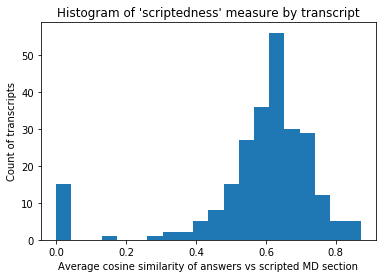

In [77]:
# Simple analysis and distribution plot for similarities

# Just build a vector of similarity scores
sim_scores = []
for day_record in results:
    for co_id in results[day_record]:
        sim_scores.append(results[day_record][co_id])
        
print "Mean sim score is", np.mean(sim_scores)
print "SD of sim scores is", np.std(sim_scores)

plt.hist(sim_scores, bins = 20)
plt.xlabel("Average cosine similarity of answers vs scripted MD section")
plt.ylabel("Count of transcripts")
plt.title("Histogram of 'scriptedness' measure by transcript")

# LDA Approach

http://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

### Install packages

In [ ]:
#!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org gensim

In [112]:
#!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org smart_open

In [78]:
import gensim

### Constructing a document-term matrix

The result of our cleaning stage is `texts`, a tokenized, stopped and stemmed list of words from a list of documents. 

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim:

In [79]:
from gensim import corpora, models

In [80]:
def testLDA_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = [t for t in tokens if not t in stop_words]
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    return stemmed_tokens

In [81]:
# Going to create a quick test approach to use LDA on
# just all the answer text

TextFiles = get_files(TEXT_PATH,'txt')
function_words = get_dictionary(LIBRARY_PATH,'function_words.txt')

texts = []
i = 0

for f in TextFiles[:100]:
    
    print "Processing file ", f
    (ticker, date, file_num) = get_filename_components(f, i)

    ts = read_transcript(f)
    
    if 'Earnings Call' in ts[0]:
        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)    
            # get the answers with a condition to ensure the answer is of at least some length
            answers = [answer for answer in QA.values() if len(answer) > 20]
            answers = [testLDA_pre_process_document(answer) for answer in answers]
            
            texts.extend(answers)
        i += 1
            

Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_AEP.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_CVX.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_MET.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_MRK.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_SPG.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_WY.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_2_AEP.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_2_CVX.txt
P

In [82]:
print len(texts)

for t in texts[:10]:
    print t

2727
[u'talk', '2010', u'guidanc']
['well', 'think', u'import', 'one', 'self', u'implement', 'number', 'michigan', 'count', '301', 'stack', 'subject', 'refund', 'go', 'forward', u'coupl', 'smaller', u'issu', 'still', u'process', u'commiss', 'think', 'get', u'decid', u'environment', u'adjust', 'ohio', u'jurisdict', 'think', 'go', u'smoothli', 'feel', u'comfort', 'hit', u'exceed', 'target', 'year']
['sure', 'let', u'handl', 'first', 'side', u'strateg', 'ask', 'brian', u'address', 'cost', u'contain', u'disciplin', u'associ', 'biggest', u'chang', u'capit', u'util', 'model', u'transmiss', u'distribut', u'gener', 'much', 'control', u'oper', u'compani', u'presid', 'logic', u'goe', 'back', 'dan', 'question', u'go', 'go', 'forward', u'manag', u'gener', 'fleet', u'compani', 'like', u'mani', u'compani', u'gener', u'capit', u'invest', u'dwarf', u'transmiss', u'invest', 'bit', 'north', u'invest', u'distribut', u'asset', u'go', 'forward', 'dialog', 'state', u'regul', u'go', u'instanc', 'coal', u'pro

The `Dictionary()` function traverses `texts`, assigning a unique integer id to each unique token while also collecting word counts and relevant statistics. 

In [83]:
dictionary = corpora.Dictionary(texts)

dictionary

To see each token’s unique integer id, try `print dictionary.token2id`.

In [84]:
print (dictionary.token2id)

{u'interchang': 2646, u'four': 652, u'francesco': 5311, u'francesca': 1576, u'payoff': 4573, u'xtp': 5497, u'accret': 3701, u'lord': 3240, u'digit': 1526, u'dell': 5845, u'connectrix': 5866, u'whitman': 1674, u'wednesday': 3755, u'terabyt': 5144, u'budget': 1257, u'270': 3877, u'second': 559, u'278': 5528, u'dialogu': 1452, u'widen': 5714, u'ongo': 1600, u'avers': 3475, u'intellectu': 5359, u'here': 3627, u'accur': 1397, u'china': 1532, u'anonym': 5100, u'deterior': 5076, u'militari': 5895, u'k': 1213, u'spotti': 4836, u'deregul': 2421, u'robin': 5523, u'controversi': 3270, u'interferon': 5599, u'carl': 4812, u'9b': 2933, u'brought': 221, u'unit': 292, u'rocksteadi': 3235, u'dna': 5584, u'spoke': 295, u'music': 3322, u'strike': 1224, u'buddi': 2800, u'relax': 1349, u'relat': 201, u'notic': 301, u'hurt': 2347, u'99': 3075, u'glass': 4342, u'holm': 3277, u'91': 2621, u'90': 855, u'midst': 580, u'hold': 1013, u'96': 460, u'accid': 3519, u'quartil': 5763, u'blade': 4191, u'conceptu': 3846,

Next, our dictionary must be converted into a bag-of-words:

In [85]:
corpus = [dictionary.doc2bow(text) for text in texts]

The doc2bow() function converts dictionary into a bag-of-words. The result, corpus, is a list of vectors equal to the number of documents. In each document vector is a series of tuples. The tuples are (term ID, term frequency) pairs, so if print(dictionary.token2id) says brocolli’s id is 0, then the first tuple indicates that brocolli appeared twice in the first document. doc2bow() only includes terms that actually occur: terms that do not occur in a document will not appear in that document’s vector.

In [86]:
print (corpus)

[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 3)], [(2, 1), (6, 1), (8, 1), (12, 6), (22, 3), (31, 5), (36, 1), (37, 1), (38, 2), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 3), (46, 1), (47, 2), (48, 1), (49, 3), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 4), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 5), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 4), (78, 2), (79, 1), (80, 3), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 4), (89, 2), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 6), (104

In [87]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=5)

The `LdaModel` class is described in detail in the gensim documentation.

https://radimrehurek.com/gensim/models/ldamodel.html

Parameters used in our example:

- `num_topics`: required. An LDA model requires the user to determine how many topics should be generated. Our document set is small, so we’re only asking for three topics.

- `id2word`: required. The `LdaModel` class requires our previous dictionary to map ids to strings.

- `passes`: optional. The number of laps the model will take through corpus. The greater the number of passes, the more accurate the model will be. A lot of passes can be slow on a very large corpus.

### Examining the results

Our LDA model is now stored as `ldamodel`. We can review our topics with the `print_topic` and `print_topics` methods:

In [88]:
print(ldamodel.print_topics(num_topics=5, num_words=10))

[(0, u'0.015*"think" + 0.014*"go" + 0.011*"look" + 0.011*"quarter" + 0.010*"busi" + 0.008*"one" + 0.006*"rate" + 0.006*"billion" + 0.006*"know" + 0.006*"right"'), (1, u'0.024*"think" + 0.011*"year" + 0.011*"well" + 0.010*"go" + 0.009*"good" + 0.008*"see" + 0.008*"get" + 0.008*"realli" + 0.007*"look" + 0.007*"thing"'), (2, u'0.023*"year" + 0.023*"quarter" + 0.018*"go" + 0.014*"think" + 0.013*"see" + 0.011*"busi" + 0.010*"well" + 0.010*"look" + 0.009*"growth" + 0.007*"expect"'), (3, u'0.010*"quarter" + 0.010*"margin" + 0.009*"go" + 0.009*"see" + 0.008*"look" + 0.008*"well" + 0.008*"expect" + 0.007*"ga" + 0.007*"think" + 0.007*"asset"'), (4, u'0.027*"think" + 0.016*"go" + 0.011*"market" + 0.010*"busi" + 0.009*"us" + 0.008*"thing" + 0.008*"time" + 0.008*"see" + 0.008*"get" + 0.008*"one"')]


In [89]:
example_doc = corpus[1]

In [90]:
# Get the distribution of probabilities across topics for a particular document
ldamodel.get_document_topics(example_doc, minimum_probability = 0)

[(0, 0.005463937464512441),
 (1, 0.0054184083075434755),
 (2, 0.97832673905482836),
 (3, 0.0053532634134685082),
 (4, 0.0054376517596473467)]

In [91]:
# Get an example word
dictionary.token2id["payoff"]

4573

In [92]:
# Get the most likely topics for a given single word
ldamodel.get_term_topics(dictionary.token2id["payoff"], minimum_probability = 0)

[(0, 1.6638811737531169e-07),
 (1, 6.4300602539189733e-06),
 (2, 1.6154729417868006e-07),
 (3, 3.6915288802301763e-07),
 (4, 1.2084686246875547e-07)]

In [93]:
# Get the top n most probable words for a topic id
ldamodel.get_topic_terms(0, topn = 7)

[(36, 0.015490490761516108),
 (12, 0.014126875783675993),
 (304, 0.01122050099118764),
 (548, 0.011111356702952808),
 (47, 0.0097773613882690905),
 (10, 0.007734199484718967),
 (76, 0.0064570176167337958)]

In [94]:
# Wrapper to print a single topic
ldamodel.print_topic(0, topn = 7)

u'0.015*"think" + 0.014*"go" + 0.011*"look" + 0.011*"quarter" + 0.010*"busi" + 0.008*"one" + 0.006*"rate"'

In [95]:
# Save a learned model to file
!mkdir -p saved_models
MODEL_DIR = WORKING_DIR+"/saved_models/"
TEST_SAVED_MODEL = MODEL_DIR + "test_saved"
ldamodel.save(TEST_SAVED_MODEL)

In [96]:
# Load a learned model from file
ldamodel2 = gensim.models.LdaModel.load(TEST_SAVED_MODEL)
ldamodel2.print_topic(0, topn = 7)

u'0.015*"think" + 0.014*"go" + 0.011*"look" + 0.011*"quarter" + 0.010*"busi" + 0.008*"one" + 0.006*"rate"'

### Assessing the quality of the topics produced.

In addition to whether the topic similarities we calculate are predictive, it would be useful to be able to assess the 'quality' of the topics produced before that, to allow us to iterate on improving topic quality as well as avoid too much 'fishing'in the final stock price data, which might create spurious correlations because of repeated tests.

There are a couple of approaches that I've researched that seem applicable.  The second below, the 'UMass' one, appears more practical for our task as it avoids evaluation against large external datasets, which might be important if our #1 task was topic coherence, but is not worth the trouble since coherence is not the primary focus for our project.


In [97]:
# Get some scoring of the quality of the topics by using a coherence
# measure.  Start with using PMI , but using corpus itself as the bencmark (not recommended
# for real, but a lot easier than doing the Google 2-grams etc)
ldamodel.top_topics(texts = texts, dictionary = dictionary, coherence = "c_uci", window_size = 2)

[([(0.027138505144451489, u'think'),
   (0.015532879016753851, u'go'),
   (0.011492507598016488, u'market'),
   (0.0104389876852651, u'busi'),
   (0.0088695702890790925, u'us'),
   (0.0082544480724895831, u'thing'),
   (0.0080187781751716782, u'time'),
   (0.0078611519723854346, u'see'),
   (0.0076189328267157828, u'get'),
   (0.0075450923624698673, u'one'),
   (0.00753473796807313, u'lot'),
   (0.0070538371926105545, u'look'),
   (0.0063176205432578713, u'know'),
   (0.0062730127014837111, u'make'),
   (0.0061371064021986518, u'peopl'),
   (0.006129818331304198, u'way'),
   (0.0058297248579469415, u'realli'),
   (0.0055843638792433051, u'take'),
   (0.0051791663686669865, u'want'),
   (0.0050938644187128118, u'well')],
  -1.0961728313149126),
 ([(0.023665651147445971, u'think'),
   (0.011430977189766982, u'year'),
   (0.010798624468971948, u'well'),
   (0.010251438543043936, u'go'),
   (0.0093048404861081051, u'good'),
   (0.0084426340030428326, u'see'),
   (0.0083363463476735979, u'g

In [98]:
# Now using the intrinsic UMass measure
ldamodel.top_topics(corpus = corpus, coherence = "u_mass")

[([(0.027138505144451489, u'think'),
   (0.015532879016753851, u'go'),
   (0.011492507598016488, u'market'),
   (0.0104389876852651, u'busi'),
   (0.0088695702890790925, u'us'),
   (0.0082544480724895831, u'thing'),
   (0.0080187781751716782, u'time'),
   (0.0078611519723854346, u'see'),
   (0.0076189328267157828, u'get'),
   (0.0075450923624698673, u'one'),
   (0.00753473796807313, u'lot'),
   (0.0070538371926105545, u'look'),
   (0.0063176205432578713, u'know'),
   (0.0062730127014837111, u'make'),
   (0.0061371064021986518, u'peopl'),
   (0.006129818331304198, u'way'),
   (0.0058297248579469415, u'realli'),
   (0.0055843638792433051, u'take'),
   (0.0051791663686669865, u'want'),
   (0.0050938644187128118, u'well')],
  -1.1575703782904163),
 ([(0.023665651147445971, u'think'),
   (0.011430977189766982, u'year'),
   (0.010798624468971948, u'well'),
   (0.010251438543043936, u'go'),
   (0.0093048404861081051, u'good'),
   (0.0084426340030428326, u'see'),
   (0.0083363463476735979, u'g

### Learn topic model, apply to Q&A pairs and evaluate similarity of Qs and As

In [116]:
# Replicating and adapting the code to build a dictionary of Q&A
# for each file so 
from collections import defaultdict

TextFiles = get_files(TEXT_PATH,'txt')
function_words = get_dictionary(LIBRARY_PATH,'function_words.txt')

texts = []
i = 0

MIN_TOKENS_NEEDED = 20  # minimum length that the Question and the Answer must
                        # both have to be considered for topic modelling and similarity

rawtext_qa = defaultdict(dict)
qa_pairs = defaultdict(dict)

for f in TextFiles[:]:
    
    print "Processing file ", f
    (ticker, date, file_num) = get_filename_components(f, i)
    
    file_id = ticker+"_"+date

    ts = read_transcript(f)
    
    if 'Earnings Call' in ts[0]:
        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)
            
            # get the QA pairs with a condition to ensure both of at least some length
            q_number = 0
            for question in QA:
                if (len(question) > MIN_TOKENS_NEEDED and
                    len(QA[question]) > MIN_TOKENS_NEEDED):
                    
                    procd_question = testLDA_pre_process_document(question)
                    procd_answer = testLDA_pre_process_document(QA[question])
                    
                    # store indexed rawtext for easier inspection later
                    rawtext_qa[file_id][q_number] = (question, QA[question])
                    
                    # store indexed processed tokens to feed model and perform inference
                    qa_pairs[file_id][q_number] = (procd_question, procd_answer)
                    q_number +=1 
                
                
            answers = [answer for answer in QA.values() if len(answer) > 20]
            answers = [testLDA_pre_process_document(answer) for answer in answers]
            
            texts.extend(answers)
        i += 1


Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_AEP.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_CVX.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_MET.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_MRK.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_SPG.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_1_WY.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_2_AEP.txt
Processing file  /Users/seddont/Dropbox/Tom/MIDS/W266_work/Working_W266/project_working/Text_Files_101217/20100730_2_CVX.txt
P

In [100]:
# Assemble a unified training texts list from all the qualifying processed Q&A pairs found
texts = []
for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        question, answer = qa_pairs[file_id][q_number]
        texts.append(question)
        texts.append(answer)

In [101]:
for t in texts:
    print t

[u'actual', u'want', 'two', u'question', u'want', 'follow', 'jim', 'last', 'question', 'demand', u'exceed', u'suppli', u'typic', 'price', u'becom', 'tool', u'situat', 'demand', 'stronger', u'suppli', 'think', u'use', 'price', 'tool', 'given', u'environ', 'airfreight', 'stuff', 'chase', u'capac']
['well', 'think', u'someth', 'omar', 'talk', 'lot', 'price', u'valu', 'relationship', u'marketplac', u'continu', u'oper', 'premium', 'brand', u'posit', 'well', u'acut', u'awar', 'price', u'valu', 'relationship', u'consum', u'continu', 'talk', 'along', u'alway', u'look', u'surgic', u'strateg', u'area', 'may', u'elast', u'price', u'continu', 'throughout', 'time', 'period', 'think', 'want', 'get', u'aggress', 'area', 'right', u'uncertainti', u'marketplac', u'someth', 'look', u'everi', 'quarter', 'take', u'line', 'market', u'assess', u'overal', 'price', u'valu', 'relationship', u'compar', 'demand', u'tri', 'make', u'decis', u'accordingli']
['hi', 'good', 'afternoon', u'guy', u'congratul']
['thank',

In [102]:
import time
# Convert the texts from all the Questions and Answers into integer form
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

start_time = time.time()
print "fitting model"
# Fit LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=30, id2word = dictionary, passes=10)
print "model fitting took", time.time() - start_time, "seconds"

fitting model
model fitting took 204.644834995 seconds


In [103]:
# Save the learned model to file
ldamodel.save(MODEL_DIR + "full_model_v01")

In [109]:
# Display top 10 terms for each topic, with intrinsic UMass measure
# of coherence
ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = 10)

[([(0.043067173286133041, u'think'),
   (0.025115010376739078, u'go'),
   (0.013972208659311095, u'look'),
   (0.013707589780722536, u'busi'),
   (0.01292744264686255, u'thing'),
   (0.01188808328048551, u'weve'),
   (0.011831513469956999, u'get'),
   (0.010713510459121341, u'lot'),
   (0.010485424465872984, u'realli'),
   (0.010271199986710637, u'that')],
  -1.3224213171587711),
 ([(0.032267805397494381, u'market'),
   (0.031398809336864876, u'busi'),
   (0.020938935967830884, u'think'),
   (0.019294903591205458, u'see'),
   (0.018316142230378592, u'continu'),
   (0.017298864615366418, u'growth'),
   (0.015236969382336136, u'well'),
   (0.014879643663228349, u'product'),
   (0.010217202140650397, u'grow'),
   (0.0098055001357648681, u'realli')],
  -1.3648848066192565),
 ([(0.036440915356322115, u'year'),
   (0.021444702451586667, u'growth'),
   (0.021199698368190377, u'rate'),
   (0.019658102829079663, u'expect'),
   (0.018321511970267948, u'2011'),
   (0.01805856993203005, u'think'),

In [114]:
# Display the coherence and topics in a little more readable form
scored_topics = ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = 10)
for t in scored_topics:
    print
    print "U_mass Coherence is ", "{:3.2f}".format(t[1])
    print "Top 10 tokens in topic are:"
    for token_tuple in t[0]:
        print "{:10}{:3.2f}".format(token_tuple[1], token_tuple[0])


U_mass Coherence is  -1.32
Top 10 tokens in topic are:
think     0.04
go        0.03
look      0.01
busi      0.01
thing     0.01
weve      0.01
get       0.01
lot       0.01
realli    0.01
that      0.01

U_mass Coherence is  -1.36
Top 10 tokens in topic are:
market    0.03
busi      0.03
think     0.02
see       0.02
continu   0.02
growth    0.02
well      0.02
product   0.01
grow      0.01
realli    0.01

U_mass Coherence is  -1.50
Top 10 tokens in topic are:
year      0.04
growth    0.02
rate      0.02
expect    0.02
2011      0.02
think     0.02
guidanc   0.02
go        0.02
q4        0.02
look      0.02

U_mass Coherence is  -1.52
Top 10 tokens in topic are:
think     0.02
product   0.02
new       0.02
us        0.02
technolog 0.02
lot       0.01
realli    0.01
busi      0.01
servic    0.01
see       0.01

U_mass Coherence is  -1.61
Top 10 tokens in topic are:
littl     0.04
bit       0.03
mayb      0.03
guess     0.03
like      0.03
question  0.02
kind      0.02
talk      0.02


In [ ]:
# Can now apply model to each question and answer pair, and calculate 
# similarity.  Going to use Hellinger distance rather than cosine similarity
# as we are comparing probability distributions.  Could also compare K-L.
# Hellinger is symmetric while K-L is not. 
# For Hellinger Distance 0 = max similarity, 1 = min similarity

In [104]:
from gensim.matutils import hellinger

hellinger_sims = defaultdict(dict)
kl_sims = defaultdict(dict)

for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        question, answer = qa_pairs[file_id][q_number]
        q_bow = dictionary.doc2bow(question)
        a_bow = dictionary.doc2bow(answer)
        lda_q_bow = ldamodel[q_bow]
        lda_a_bow = ldamodel[a_bow]
        hellinger_sims[file_id][q_number] = hellinger(lda_q_bow, lda_a_bow)
        

Mean similarity 0.504121290235
SD similarity 0.129371907318


(0.66754982265008822, ('NKE_20100923', 0))

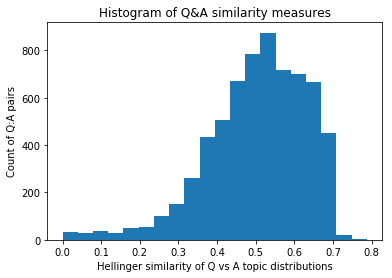

In [127]:
# Create a vector for all the similarity scores
all_sims = []
for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        all_sims.append((hellinger_sims[file_id][q_number],(file_id, q_number)))

sim_vals = [v[0] for v in all_sims]
print "Mean similarity", np.mean(sim_vals)
print "SD similarity", np.std(sim_vals)

plt.hist(sim_vals, bins = 20)
plt.xlabel("Hellinger similarity of Q vs A topic distributions")
plt.ylabel("Count of Q:A pairs")
plt.title("Histogram of Q&A similarity measures")

In [131]:
from operator import itemgetter
all_sims.sort(key=itemgetter(0))
all_sims

[(4.082240392577815e-15, ('HNZ_20101119', 8)),
 (8.0074715392872528e-15, ('CVX_20110128', 30)),
 (8.0859761622214422e-15, ('HSH_20100812', 25)),
 (8.7925177686291403e-15, ('DHR_20101021', 26)),
 (1.4680364488693295e-14, ('UTX_20110126', 40)),
 (1.4837373734561674e-14, ('CPB_20100903', 33)),
 (1.7271017045521526e-14, ('DOW_20110203', 25)),
 (4.576819517063204e-14, ('MMM_20101028', 29)),
 (1.2953262784141145e-13, ('MA_20100803', 14)),
 (3.0773995214824958e-13, ('MON_20101006', 13)),
 (4.6804456193363331e-13, ('CPB_20101123', 27)),
 (7.1894533683130063e-13, ('TWX_20110202', 1)),
 (0.0088243268572942447, ('MMM_20101028', 22)),
 (0.0093274790045341886, ('HSH_20100812', 17)),
 (0.010995817767321954, ('CVX_20110128', 8)),
 (0.012560011482256394, ('MMM_20101028', 20)),
 (0.012560011482262753, ('GE_20110121', 55)),
 (0.015017377529731835, ('GS_20110119', 10)),
 (0.019320189378157469, ('TWX_20101103', 13)),
 (0.019320189378181099, ('EMR_20101102', 44)),
 (0.019320189378197274, ('UPS_20110201', 2

In [141]:
# Display the closest n based on distance between q and a

n = 3
for record in all_sims[:n]:
    print
    print "Hellinger Distance of topics is {:4.3f}".format(record[0])
    q_text, a_text = rawtext_qa[record[1][0]][record[1][1]]
    print "Question:"
    print q_text
    print "Answer:"
    print a_text


Hellinger Distance of topics is 0.000
Question:
Thank you, and good morning, everyone.
Answer:
Good morning. Good morning.

Hellinger Distance of topics is 0.000
Question:
Okay, great. Thanks very much.
Answer:
Okay, one more question, thank you.

Hellinger Distance of topics is 0.000
Question:
Thanks. Good morning.
Answer:
Good morning. Morning.


In [144]:
# Display the furthest n based on distance between q and a

n = 3
for record in all_sims[-n:]:
    print
    print "Hellinger Distance of topics is {:4.3f}".format(record[0])
    q_text, a_text = rawtext_qa[record[1][0]][record[1][1]]
    print "Question:"
    print q_text
    print "Answer:"
    print a_text


Hellinger Distance of topics is 0.758
Question:
And you referenced the economy in your opening comments, Tom, how does that factor into the roll out? And have you seen the impact of that in the test area of this new product? Thank you for answering my questions.
Answer:
I dont really think it impacts the rollout much. The rollout is going to be when Matts ready to hit the accelerator and were ready to go. And he and Joe feel like this system will put a lot of that product through it. But the economy has made people much more risk averse, much more willing to save money and think about their future as opposed to just current consumption. So we think, from an overall macro perspective, this focusing on their needs, their focus on cash, and to think longer term will be in the sweet spot, but it doesnt really impact the roll out. The roll out will be based on doing it right.

Hellinger Distance of topics is 0.762
Question:
Good morning. It's D.A. Davidson. Marcel, it's been previously sta

In [145]:
n = 3
for record in all_sims[-n:]:
    print record

(0.75824251409003607, ('ALL_20100805', 3))
(0.76200914294154365, ('HSH_20110208', 19))
(0.7881005195380838, ('GD_20110126', 14))


In [148]:
question, answer = qa_pairs['HSH_20110208'][19]
print question
print answer
q_bow = dictionary.doc2bow(question)
a_bow = dictionary.doc2bow(answer)
lda_q_bow = ldamodel[q_bow]
lda_a_bow = ldamodel[a_bow]
print lda_q_bow
print lda_a_bow

['good', u'morn', 'davidson', 'marcel', u'previous', u'state', 'north', 'american', 'retail', 'margin', u'dollar', 'year', u'term', 'ebit', u'unexpect', 'downtick', u'meaning', 'downtick', 'still', u'confid', 'true', 'full', 'year', '2011']
['tim', u'cours', 'closest', 'file', u'anybodi', 'expert', u'keep', 'us', u'promis', 'thank', 'question', 'answer', u'ye', u'ye', 'said', 'see', u'anoth', 'uptick', 'margin', 'still', 'think', u'deliv']
[(2, 0.13456290349615607), (4, 0.32486960041754609), (9, 0.05324601792258693), (14, 0.3540290604658537), (19, 0.099959084364491635)]
[(9, 0.43863983742619567), (18, 0.11340346130248842), (23, 0.17949576350078905), (24, 0.12330002296058984), (25, 0.1089290307519318)]


In [153]:
# Display topics
print ldamodel.print_topic(4, topn = 7)
print
print ldamodel.print_topic(14, topn = 7)

0.036*"year" + 0.021*"growth" + 0.021*"rate" + 0.020*"expect" + 0.018*"2011" + 0.018*"think" + 0.016*"guidanc"

0.052*"north" + 0.049*"america" + 0.048*"europ" + 0.016*"see" + 0.015*"pump" + 0.015*"u" + 0.014*"liquid"


In [154]:
# Display topics
print ldamodel.print_topic(9, topn = 7)
print
print ldamodel.print_topic(23, topn = 7)

0.031*"capit" + 0.027*"share" + 0.025*"cash" + 0.023*"go" + 0.022*"plan" + 0.017*"debt" + 0.017*"dividend"

0.044*"go" + 0.041*"well" + 0.023*"think" + 0.021*"get" + 0.017*"work" + 0.013*"time" + 0.013*"us"


In [117]:
# Calc some state on hellinger similarity and identify max and min
max_dist = -1
min_dist = 2
max_record_id = (None, None)
min_record_id = (None, None)

for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        this_sim = hellinger_sims[file_id][q_number]
        if this_sim > max_dist:
            max_dist = this_sim
            max_record_id = (file_id, q_number)
        if this_sim < min_dist:
            min_dist = this_sim
            min_record_id = (file_id, q_number)
        
        
print max_sim
print max_record_id
print qa_pairs[max_record_id[0]][max_record_id[1]]
print rawtext_qa[max_record_id[0]][max_record_id[1]]
print
print min_sim
print min_record_id
print qa_pairs[min_record_id[0]][min_record_id[1]]
print rawtext_qa[min_record_id[0]][min_record_id[1]]

0.788100519538
('GD_20110126', 14)
(['okay', 'given', u'comment', 'flat', 'outlook', u'defens', u'spend', u'see', 'backdrop', u'environ', 'jay', 'think', u'import', u'opportunist', u'buy', u'defens', u'properti', 'might', u'otherwis', u'distress', u'certainli', u'neg', 'sentiment', 'overhang', u'inclin', 'say', 'know', u'commerci', u'entiti', 'like', u'increas', 'scale', 'buy', u'share'], ['well', 'mean', 'think', 'know', u'myle', 'look', u'chang', u'direct', u'busi', 'unit', u'presid', '13', 'within', 'sphere', u'busi', 'look', u'opportun', 'grow', u'busi', u'acquisit', 'core', u'addit', 'core', u'believ', u'defens', u'environ', u'opportun', 'come', u'avail', u'adjac', 'dual', 'use', u'commerci', 'bet', u'look', u'thing', u'addit', u'cours', u'aerospac', 'growth', u'engin', 'intend', 'take', u'advantag'])
("Okay. And then given the comments on the flat outlook for defense spending what you're seeing in the backdrop, is this the environment where, Jay, you think it's more important to 

In [106]:
sum(len(qa_pairs[f]) for f in qa_pairs)

6587

In [107]:
# Display a few stats about the q&a data
print "Number of files", len(qa_pairs.keys())
print "Total number of Q&A pairs evaluated", sum(len(qa_pairs[f]) for f in qa_pairs)
total_tokens = 0
for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        len_q = len(qa_pairs[file_id][q_number][0])
        len_a = len(qa_pairs[file_id][q_number][1])
        total_tokens += (len_q + len_a)
print "Total number of tokens", total_tokens

Number of files 249
Total number of Q&A pairs evaluated 6587
Total number of tokens 593441


### Old code

In [49]:
# READ IN DICTIONARIES

def get_full_dict():
    """Read in the full McDonald and Loughran word list dictionary as a list"""
    file_path = dict_path + dict_name
    with open(file_path, "r") as file:
        words = [word.lower().rstrip('\n').split(',') for word in file]
    words_only = []
    for i in range(len(words)):
        words_only.append(words[i][0])
    return words_only


def get_bytes_replace_dict():
    """Read in the Non-UTF8 character dictionary as a dict with key=byte character, value=utf-8 character"""
    file_path = dict_path + bytes_dict_name
    with open(file_path, "r") as file:
        words = [word.rstrip('\n').split('\t') for word in file]
    bytes_replace_dict = {}
    for i in range(1, len(words)):
        bytes_replace_dict[words[i][1]] = words[i][2]
    return bytes_replace_dict


def get_result_file(result_name):
    """Result_name is a result file that is a '#' separated file"""
    file_path = dict_path + result_name
    with open(file_path, "r") as file:
        results = [word.rstrip('\n').split('#') for word in file]
    return results


# BASIC STRING FUNCTIONS

def remove_punctuation(my_string):
    """Remove all ASCII punctuation from my_string"""
    # NEED TO INCLUDE NO-UTF8 apostrophe replace
    my_str = short_form_replace(my_string)  # replace short forms with long forms before removing punctuation
    # my_str = ''.join(l for l in my_str if l not in string.punctuation)
    my_punc_remove = "-"
    my_punc = ''.join(l for l in string.punctuation if l not in my_punc_remove)
    my_str = ''.join(l for l in my_str if l not in my_punc)
    my_str = ' '.join(my_str.split())     # this changes all white spaces to single spaces
    return my_str


def remove_digits(my_string):
    """Remove all ASCII digits from my_string"""
    my_str = ''.join(l for l in my_string if l not in string.digits)
    my_str = ' '.join(my_str.split())     # this changes all white spaces to single spaces
    return my_str


def count_chars_words(my_string):
    """Number of characters and words in my_string. Numbers are deemed to be a word."""
    my_str = remove_punctuation(my_string)
    words = my_str.split(' ')
    num_words = len(words)
    num_chars = 0
    for word in words:
        num_chars += len(word)
    return num_chars, num_words


def count_words(my_string):
    """Number of words in my_string. Numbers are deemed to be a word."""
    my_str = remove_punctuation(my_string)
    words = my_str.split(' ')
    num_words = len(words)
    return num_words


def count_sentences(my_string):
    """Count the number of sentences in my_string"""
    my_str = my_string.rstrip()
    sent_ends = '.!?'
    num_sent = 0
    if len(my_str) < 2:
        return num_sent
    else:
        for i in range(2, len(my_str) - 2):
            # check for abbreviations like U.S.A. or e.g. or i.e. followed by a space then upper case letter
            if not(my_str[i] == my_str[i-2] == '.' and my_str[i-1] in string.ascii_letters):
                # check for sentence ending punctuation followed by a space and then an upper case letter
                if my_str[i] in sent_ends and my_str[i + 1] == ' ' and my_str[i + 2] in string.ascii_uppercase:
                    num_sent += 1
    # check special case of last character being a sentence end
    if my_str[-1] in sent_ends:
        num_sent += 1
    return num_sent


def convert_string_to_words(my_string):
    """Convert a string to a list of words"""
    my_str = remove_punctuation(my_string)
    my_str = remove_digits(my_str)
    words = my_str.split(' ')
    return words


def unique_words(my_string):
    """Create a list of unique words that appear in my_string"""
    words = set(convert_string_to_words(my_string))
    return words

def count_in_string(my_string):
    """Count the frequency of words in my_string"""
    words = convert_string_to_words(my_string)
    count = {word: words.count(word) for word in words}
    return count

# STRING FUNCTIONS THAT RELATE TO A DICTIONARY


def sum_in_words(my_string, words):
    """Total count of words in my_string that appear in the list words"""
    my_str = convert_string_to_words(my_string)
    count = sum([1 for word in my_str if word in words])
    return count


def count_in_words(my_string, words):
    """Frequency/count of each word in my_string that appear in the list words"""
    my_str = convert_string_to_words(my_string)
    count = {word: my_str.count(word) for word in words}
    return count


def remove_duplicates(count_dict):
    """Receives a count_in_words dictionary and returns a list of the unique words, i.e. only appear once."""
    unique_words_in_count = [key for key in count_dict.keys() if count_dict[key] == 1]
    return unique_words_in_count


def not_in_dictionary(my_string, words):
    """Returns a list of words that are in my_string, but not in the list words"""
    not_in = [word for word in unique_words(my_string.lower()) if word not in set(words)]
    return not_in


# COLLECT WORD TYPES FROM CORPUS

def short_form_replace_check(my_string):
    """Return a list of all short-form words or words with apostrophes in my_string"""
    result = []
    my_str = my_string
    for j in range(len(my_str)):
        if my_str[j] == '\'':
            n = j
            while my_str[n] != ' ':
                n += 1
                if n == len(my_str) - 1:
                    break
            m = j
            while my_str[m] != ' ':
                m -= 1
                if m == 0:
                    break
            result.append(my_str[m + 1:n].lower())
    result = sorted(list(set(result)))
    return result


def find_non_utf8_chars(my_string):
    """Returns a dict of all non-utf-8 characters with their byte encoded character and frequency from my_string"""
    my_str = my_string
    result = {}
    for char in my_str:
        if len(str(char.encode('utf-8'))) > 5:
            if char in result:
                result[char][1] += 1
            else:
                result[char] = [char.encode('utf-8'), 0]
    return result

def replace_non_utf8_apostrophes(my_str):
    """Replace most common non-utf-8 apostrophes with utf-8 apostrophes"""
    apostrophes = [str(b'\xe2\x80\x98'), str(b'\xe2\x80\x99')]
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in apostrophes:
            my_str = my_str[:i] + "'" + my_str[i+1:]
    return my_str



# CHECK THIS!!!!
def fi_replace(my_str):
    """Replace missing "fi's" in words that need them."""
    my_str = re.sub(r"(\s)(\?)([a-z])", r" fi\3", my_str)
    my_str = re.sub(r"(\s)(\?)(\s)([a-z])", r" fi\4", my_str)
    my_str = re.sub(r"([A-z])(\?)([a-z])", r"\1fi\3", my_str)
    my_str = re.sub(r"([A-z])(\?)(\s)([a-z])", r"\1fi\4", my_str)
    return my_str


def replace_non_utf8_chars(my_str):
    """Replace all non-utf8 characters with the user defined characters in the bytes_replace_dict"""
    byte_dict = get_bytes_replace_dict()
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in byte_dict:
            byte_key = str(my_str[i].encode('utf-8'))
            my_str = my_str[:i] + byte_dict[byte_key] + my_str[i+1:]
    my_str = my_str.replace('""""', '"')
    my_str = my_str.replace('\\\'', '\'')
    return my_str


def replace_fi_fl(my_str):
    """Replace 'fi' in any word that includes 'fi', where the word is not in the all_words dictionary,
    but where the word with 'fl' in place of 'fi' is in the all_words dictionary"""
    all_words = get_dictionary('All_words.txt')
    words = my_str.split(' ')
    for i in range(len(words)):
        if 'fi' in words[i]:
            if words[i] not in all_words:
                if words[i].replace('fi', 'fl') in all_words:
                    words[i] = words[i].replace('fi', 'fl')
    my_str = ' '.join(words)
    return my_str


def v1_v2_frequency_in_words(my_string1, my_string2, words):
    """Takes two strings and returns word matched frequency vectors ('a' & 'b') for a given dictionary 'words',
     which is useful for cosine similarity analysis."""
    count1 = count_in_words(my_string1, words)  # returns dict(keys:word in words, values:word frequency)
    count2 = count_in_words(my_string2, words)  # returns dict keys:word in words, values:word frequency)
    a = []
    b = []
    for key in count1.keys():                     # create two word frequency vectors 'a' and 'b'
        a.append(count1[key])
        b.append(count2[key])
    return a, b


def ferret(my_string1, my_string2, num_grams=3):
    """calculate the proportion of matching num_grams between two strings. It is useful for
    determining how correlated two strings are hence their relative informational value"""
    # converts strings to single word lists
    words1 = convert_string_to_words(my_string1.lower())
    words2 = convert_string_to_words(my_string2.lower())
    # aggregate single words into multi-word strings or num_grams, default is 3 or trigrams
    num_grams1 = []
    num_grams2 = []
    for i in range(num_grams-1, len(words1)):
        string1 = ''
        for j in range(num_grams - 1, -1, -1):
            if j != 0:
                string1 += words1[i - j] + ' '
            else:
                string1 += words1[i - j]
        num_grams1.append(string1)
    for i in range(num_grams-1, len(words2)):
        string2 = ''
        for j in range(num_grams - 1, -1, -1):
            if j != 0:
                string2 += words2[i - j] + ' '
            else:
                string2 += words2[i - j]
        num_grams2.append(string2)
    # find unique num_grams from my_strings
    num_grams1 = set(num_grams1)
    num_grams2 = set(num_grams2)
    # find union and intersection of the num_grams lists
    num_grams_total = num_grams1.union(num_grams2)
    num_grams_identical = num_grams1.intersection(num_grams2)
    print(num_grams1)
    print(num_grams2)
    print(num_grams_identical)
    print(num_grams_total)
    # calculate ratio of intersection to union of num_grams between my_strings
    if num_grams_total == 0:
        result = ''
    else:
        result = len(num_grams_identical) / len(num_grams_total)
    return result


def coleman_liau(my_string):
    """Returns the Coleman-Liau readability algorithm score for the string my_string"""
    characters, words = count_chars_words(my_string)
    sentences = count_sentences(my_string)
    result = ''
    if words != 0:
        result = 0.0588 * (100 * characters / words) - 0.296 * (100 * sentences / words) - 15.8
    return result


def automated_readability(my_string):
    """Returns the automated readability index algorithm score for the string my_string"""
    characters, words = count_chars_words(my_string)
    sentences = count_sentences(my_string)
    result = ''
    if words != 0 or sentences != 0:
        result = int(4.71 * (characters / words) + 0.5 * (words / sentences) - 21.43) + 1
    return result

def count_in_words(words):
    """Count the frequency of words in words list"""
    count = {word: words.count(word) for word in words}
    return count

def doc_count_in_word_list(words, word_list):
    """Count the frequency of words in a document from a word list"""
    count = {word: words.count(word) for word in word_list}
    return count



In [ ]:
# Get QA Section
start = find_full_string_index(ts, QA_SECTION_HEADERS)
end = find_disclaimer_index(ts,DISCLAIMER)
agg_names = co_part_names + oth_part_names + ['Unknown Oth Part'] + ['Unknown Co Part']
pts = []
process_qa_section(ts, pts, agg_names, start, end)

In [ ]:

def process_qa_section(ts, pts, names, start_index, end_index):

    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    # create dict for comments by each participant
    section_dict = {key: "" for key in names}
    curr_speaker = 'Operator'

    for line in qa_section:
        if len(line) > 0:
            if line == 'Operator':
                curr_speaker = 'Operator'
            if line[0] == "<":
                if line[0:4] == "<Q>:":
                    section_dict['Unknown Oth Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Oth Part'
                if line[0:4] == "<A>:":
                    section_dict['Unknown Co Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Co Part'
                if line[2:5] == " - ":
                    name_end = line.find(">")
                    name = line[5:name_end]
                    if name in section_dict.keys():
                        section_dict[name] += line[name_end+3:] + " "
                    curr_speaker = name
            else:
                if curr_speaker in section_dict.keys():
                    section_dict[curr_speaker] += line + " "

    # print speaker and their comments
    pts.append("Q&A Section: Speaker and Comments")
    for name in names:
        pts.append(name + ": " + section_dict[name])
    return pts



In [37]:

def get_dir(path1):
    return os.listdir(path1)

def copy_pdf():
    directories = get_dir(EXTRACT_PATH2)
    directories = [EXTRACT_PATH2 + directory + "/" for directory in directories]
    for directory in directories:
        print(directory)
        file_list = get_files(directory, "pdf")
        for file in file_list:
            print(file)
            shutil.copy2(file, PDF_PATH2)

def get_pdf_names(path1):
    pdf_list = glob.glob(path1 + "*.pdf")
    with open(path1 + "PDF_files.txt", "w") as file:
        for pdf in pdf_list:
            file.write(pdf + "\n")

def get_file_details():

    file_list = get_files(myTXT_PATH, "txt")

    for i in file_list:

        with open(i, "r") as file:
            ts = [line.rstrip('\n') for line in file]

        name = ''
        code = ''
        date = ''
        event = ''

        if len(ts) >= 1 and len(ts[0]) > 14:
            name = ts[0][14:]
        if len(ts) >= 2 and len(ts[0]) > 16:
            code = ts[1][16:19]
        if len(ts) >= 3 and len(ts[0]) > 6:
            date = ts[2][6:]
        if len(ts) >= 4 and len(ts[0]) > 19:
            event = ts[3][19:]

        print(i+",", name+",", code+",", date+",", event)

def find_part_string_index(ts, string_list):
    result = -1
    k = 0
    while True:
        for my_str in string_list:
            if ts[k].strip() == my_str:
                result = k
                break
            # Check for small typo (additional leading or lagging chars) in the header - only one is BHP
            if ts[k].find(my_str) != -1 and len(ts[k]) < len(my_str) + 5:
                result = k
                break
        k += 1
        if k == len(ts):
            break
    return result


def get_processed_parts(ts, start_index, end_index):
    result = [name[re.search("[a-z]", name.lower()).start():] for name in ts[start_index+1:end_index] if len(name) >= 3]
    return result



def process_transcript(transcript, processed_transcript, print_ts="N"):

    # print transcript
    if print_ts == "Y":
        for item in transcript:
            print(item)

    # collect indices
    co_parts_index = find_full_string_index(transcript, CO_PART_HEADERS)
    if co_parts_index == -1:
        co_parts_index = find_part_string_index(transcript, CO_PART_HEADERS)

    oth_parts_index = find_full_string_index(transcript, OTH_PART_HEADERS)
    if oth_parts_index == -1:
        oth_parts_index = find_part_string_index(transcript, OTH_PART_HEADERS)

    md_section_index = find_full_string_index(transcript, MD_SECTION_HEADERS)
    if md_section_index == -1:
        md_section_index = find_part_string_index(transcript, MD_SECTION_HEADERS)

    qa_section_index = find_full_string_index(transcript, QA_SECTION_HEADERS)
    if qa_section_index == -1:
        qa_section_index = find_part_string_index(transcript, QA_SECTION_HEADERS)

    disclaimer_index = find_disclaimer_index(transcript, DISCLAIMER)

    problem_inds = [md_section_index, disclaimer_index]

    if -1 in problem_inds:
        processed_transcript.append("Index problem")
        print(problem_inds)
    else:
        # Any company participants found?
        if co_parts_index == -1:
            co_parts_index = md_section_index

        # No other participants found
        if oth_parts_index == -1:
            oth_parts_index = md_section_index

        # Collect and write company participants
        if co_parts_index != md_section_index:
            co_parts = get_parts(transcript, co_parts_index, oth_parts_index)
        else:
            co_parts = ['Unknown Co Part']
        processed_transcript.append("Company Participants")
        for item in co_parts:
            processed_transcript.append(item)
        processed_transcript.append("")

        # Collect and write other participants
        if oth_parts_index != md_section_index:
            oth_parts = get_parts(transcript, oth_parts_index, md_section_index)
        else:
            oth_parts = ['Unknown Oth Part']
        processed_transcript.append("Other Participants")
        for item in oth_parts:
            processed_transcript.append(item)
        processed_transcript.append("")

        # Further checks to find the start of Q&A section
        qa_type = 0
        if qa_section_index == -1:
            k = len(transcript)+1
            for line in range(md_section_index, len(transcript)):
                if transcript[line][0:2] == '<Q':
                    if line < k:
                        k = line
                        qa_type = 1
            if qa_type == 1:
                qa_section_index = k-1
            else:
                if oth_parts != ['Unknown Oth Part']:
                    k = len(transcript)+1
                    for line in range(md_section_index, len(transcript)):
                        for name in oth_parts:
                            if transcript[line].find(name) != -1:
                                if line < k:
                                    k = line
                    if k != len(transcript)+1:
                        qa_section_index = k-1

        # There appears to be no QA section
        if qa_section_index == -1:
            qa_section_index = disclaimer_index

        result = [co_parts_index, oth_parts_index, md_section_index, qa_section_index, disclaimer_index]
        print(result)

        # collect and write comments by participant in the MD section
        if co_parts == ['Unknown Co Part']:
            processed_transcript = process_md_no_names(transcript, processed_transcript, co_parts, md_section_index, qa_section_index)
        else:
            processed_transcript = process_section(transcript, processed_transcript, co_parts, md_section_index, qa_section_index, "MD")
        processed_transcript.append("")

        # collect and write comments by participant in the QA section
        if qa_section_index == disclaimer_index:
            processed_transcript.append("Q&A Section: Speaker and Comments")
            processed_transcript.append("No Q&A section")
        else:
            # collect and print comments by participant in the Q&A section
            all_parts = co_parts + oth_parts + ["Operator"]
            if "Unknown Co Part" not in all_parts:
                all_parts.append("Unknown Co Part")
            if "Unknown Oth Part" not in all_parts:
                all_parts.append("Unknown Oth Part")

            if "Q&A" in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif "QUESTION AND ANSWER SECTION"  in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif "QUESTION AND ANSWER SESSION" in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif qa_type == 1:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            else:
                processed_transcript = process_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index, "Q&A")
            processed_transcript.append("")
    return processed_transcript





def process_qa_section(ts, pts, names, start_index, end_index,):

    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    # create dict for comments by each participant
    section_dict = {key: "" for key in names}
    curr_speaker = 'Operator'

    for line in qa_section:
        if len(line) > 0:
            if line == 'Operator':
                curr_speaker = 'Operator'
            if line[0] == "<":
                if line[0:4] == "<Q>:":
                    section_dict['Unknown Oth Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Oth Part'
                if line[0:4] == "<A>:":
                    section_dict['Unknown Co Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Co Part'
                if line[2:5] == " - ":
                    name_end = line.find(">")
                    name = line[5:name_end]
                    if name in section_dict.keys():
                        section_dict[name] += line[name_end+3:] + " "
                    curr_speaker = name
            else:
                if curr_speaker in section_dict.keys():
                    section_dict[curr_speaker] += line + " "

    # print speaker and their comments
    pts.append("Q&A Section: Speaker and Comments")
    for name in names:
        pts.append(name + ": " + section_dict[name])
    return pts


def process_raw_files():
    my_file_list = sorted(get_files(TXT_PATH, "txt"))
    for i, file_path in enumerate(my_file_list):
        print(i, file_path[len(TXT_PATH):])
        pro_ts = [file_path[len(TXT_PATH):]]
        # read in the transcript
        my_text = read_transcript(file_path)
        # check if the file is an earnings call
        if my_text[0].find("Earnings Call") != -1:
            # process the transcript
            pro_ts = process_transcript(my_text, pro_ts, "N")

            process_error = -1
            for item in pro_ts:
                if item.find('Could not find the start ') != -1:
                    process_error = 1
                if item.find('Index problem') != -1:
                    process_error = 1

            if process_error == 1:
                file = open(F_TXT_PATH+pro_ts[0], "w")
            else:
                file = open(P_TXT_PATH+pro_ts[0], "w")
            for item in pro_ts:
                # note the split removes unnecessary white spaces including page breaks
                file.write(' '.join(item.split()) + "\n")
            file.close()


def get_MD(ts, start, end):
    section = ts[start+1:end-1]
    MD_section = ""
    for string in section:
        colon_index = string.find(":")
        if colon_index != len(string)-1:
            MD_section += string[colon_index+2:] + " "
    return MD_section


def get_QA(ts, co_parts, oth_parts, start):
    section = ts[start+1:]
    QA_section_co = ""
    QA_section_oth = ""
    for string in section:
        colon_index = string.find(":")
        part = string[:colon_index]
        if colon_index != len(string)-1:
            if part in co_parts:
                QA_section_co += string[colon_index+2:] + " "
            if part in oth_parts:
                QA_section_oth += string[colon_index+2:] + " "
    return QA_section_co, QA_section_oth


def process_processed_transcript(transcript, dict_list1, dict_list2):

    results = []
    results2 = []

    co_parts_index = find_full_string_index(transcript, ['Company Participants'])
    oth_parts_index = find_full_string_index(transcript, ['Other Participants'])
    md_section_index = find_full_string_index(transcript, ['MD Section: Speaker and Comments'])
    qa_section_index = find_full_string_index(transcript, ['Q&A Section: Speaker and Comments'])

    # collect and print company participants
    co_parts = get_processed_parts(transcript, co_parts_index, oth_parts_index)
    if 'Unknown Co Part' not in co_parts:
        co_parts.append('Unknown Co Part')

    # collect and print other participants
    oth_parts = get_processed_parts(transcript, oth_parts_index, md_section_index)
    if 'Unknown Oth Part' not in co_parts:
        co_parts.append('Unknown Oth Part')

    # collect comments in the MD section
    MD_section = get_MD(transcript, md_section_index, qa_section_index)

    # collect and print comments by participant group in the Q&A section
    no_QA = False
    if 'No Q&A section' in transcript:
        no_QA = True
    else:
        QA_section_co, QA_section_oth = get_QA(transcript, co_parts, oth_parts, qa_section_index)

    # MD_words = tt.convert_string_to_words(tt.clean_text(MD_section.lower()))
    # QA_words_co = tt.convert_string_to_words(tt.clean_text(QA_section_co.lower()))
    # QA_words_oth = tt.convert_string_to_words(tt.clean_text(QA_section_oth.lower()))

    MD_words = tt.clean_text(MD_section.lower())
    if not no_QA:
        QA_words_co = tt.clean_text(QA_section_co.lower())
        QA_words_oth = tt.clean_text(QA_section_oth.lower())

    cv = CountVectorizer(ngram_range=(1,2))
    analyze = cv.build_analyzer()

    st_word_counts = {key: 0 for key in dict_list1}
    lt_word_counts = {key: 0 for key in dict_list2}

    # process MD section
    words = analyze(MD_words)
    word_counts_st = {word: words.count(word) for word in dict_list1}
    word_counts_lt = {word: words.count(word) for word in dict_list2}
    tot_num = len(MD_words)
    st_num = sum(word_counts_st.values())
    lt_num = sum(word_counts_lt.values())
    if st_num+lt_num == 0:
        ratio = "NA"
    else:
        ratio = round(100*st_num/(st_num+lt_num),1)
    # print(st_num, lt_num, ratio, tot_num)
    results.append('MD section')
    results.append(str(word_counts_st))
    results.append(str(word_counts_lt))
    results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
    results2.append(st_num)
    results2.append(lt_num)
    results2.append(tot_num)
    for key in st_word_counts.keys():
        st_word_counts[key] += word_counts_st[key]
    for key in lt_word_counts.keys():
        lt_word_counts[key] += word_counts_lt[key]

    # process QA sections
    if not no_QA:
        words = analyze(QA_words_co)
        word_counts_st = {word: words.count(word) for word in dict_list1}
        word_counts_lt = {word: words.count(word) for word in dict_list2}
        tot_num = len(QA_words_co)
        st_num = sum(word_counts_st.values())
        lt_num = sum(word_counts_lt.values())
        if st_num+lt_num == 0:
            ratio = "NA"
        else:
            ratio = round(100*st_num/(st_num+lt_num),1)
        results.append('QA Co section')
        results.append(str(word_counts_st))
        results.append(str(word_counts_lt))
        results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
        results2.append(st_num)
        results2.append(lt_num)
        results2.append(tot_num)
        for key in st_word_counts.keys():
            st_word_counts[key] += word_counts_st[key]
        for key in lt_word_counts.keys():
            lt_word_counts[key] += word_counts_lt[key]
    else:
        results.append('QA Co section')
        results.append('No QA section')
        results2.append('NA')
        results2.append('NA')
        results2.append('NA')

    if not no_QA:
        words = analyze(QA_words_oth)
        word_counts_st = {word: words.count(word) for word in dict_list1}
        word_counts_lt = {word: words.count(word) for word in dict_list2}
        tot_num = len(QA_words_oth)
        st_num = sum(word_counts_st.values())
        lt_num = sum(word_counts_lt.values())
        if st_num+lt_num == 0:
            ratio = "NA"
        else:
            ratio = round(100*st_num/(st_num+lt_num),1)
        results.append('QA Oth section')
        results.append(str(word_counts_st))
        results.append(str(word_counts_lt))
        results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
        results2.append(st_num)
        results2.append(lt_num)
        results2.append(tot_num)
        for key in st_word_counts.keys():
            st_word_counts[key] += word_counts_st[key]
        for key in lt_word_counts.keys():
            lt_word_counts[key] += word_counts_lt[key]
    else:
        results.append('QA Oth section')
        results.append('No QA section')
        results2.append('NA')
        results2.append('NA')
        results2.append('NA')

#    return results
    return results2, st_word_counts, lt_word_counts


def process_processed_files():
    my_file_list = sorted(get_files(P_TXT_PATH, "txt"))
    # empty results file
    file = open(RESULTS_PATH + "results.csv", "w")
    file.write("File,MD_st,MD_lt,MD_tot,QACo_st,QACo_lt,QACo_tot,QAOth_st,QAOth_lt,QAOth_tot" + "\n")
    file.close()
    # Create empty dictionaries
    st_words = {key: 0 for key in SHORT_TERM}
    lt_words = {key: 0 for key in LONG_TERM}
    # crunch numbers for each transcript
    for i, file_path in enumerate(my_file_list):
        print(i, file_path[len(P_TXT_PATH):])
        my_text = read_transcript(file_path)
        result, st_word_counts, lt_word_counts = process_processed_transcript(my_text, SHORT_TERM, LONG_TERM)
        for key in st_words.keys():
            st_words[key] += st_word_counts[key]
        for key in lt_words.keys():
            lt_words[key] += lt_word_counts[key]
        # append to file
        file = open(RESULTS_PATH + "results.csv", "a")
        file.write(file_path[len(P_TXT_PATH):] + ",")
        file.write(str(result[0]))
        for item in result[1:]:
            file.write("," + str(item))
        file.write("\n")
        file.close()
    print("ST words")
    for key, value in st_words.items():
        print(key + ": " + str(value))
    print("LT words")
    for key, value in lt_words.items():
        print(key + ": " + str(value))


def process_processed_file(file_name):
    # Create empty dictionaries
    st_words = {key: 0 for key in SHORT_TERM}
    lt_words = {key: 0 for key in LONG_TERM}
    # crunch numbers for each transcript

    my_text = read_transcript(P_TXT_PATH + file_name)
    result, st_word_counts, lt_word_counts = process_processed_transcript(my_text)
    for key in st_words.keys():
        st_words[key] += st_word_counts[key]
    for key in lt_words.keys():
        lt_words[key] += lt_word_counts[key]
    print(file_name)
    my_str = str(result[0])
    for item in result[1:]:
        my_str += "," + str(item)
    print(my_str)
    print("ST words")
    for key, value in st_words.items():
        print(key + ": " + str(value))
    print("LT words")
    for key, value in lt_words.items():
        print(key + ": " + str(value))


def process_raw_file(file_name):
    # read in the transcript
    my_text = read_transcript(TXT_PATH + file_name)
    # check if the file is an earnings call
    pro_ts = [file_name]
    if my_text[0].find("Earnings Call") != -1:
        # process the transcript
        pro_ts = process_transcript(my_text, pro_ts, "Y")
        process_error = -1
        for item in pro_ts:
            # note the split removes unnecessary white spaces including page breaks
            print(' '.join(item.split()) + "\n")


def alpha_ideas_compare_two_dicts(files_path, results_path, result_file, dict1, dict2):

    # get list of pre-processed file names and path
    my_file_list = sorted(get_files(files_path, "txt"))

    # Ensure the results file is empty and write a header
    with open(results_path + result_file, "w") as my_result_file:
        my_result_file.write("File,MD_d1,MD_d2,MD_tot,QACo_d1,QACo_d2,QACo_tot,QAOth_d1,QAOth_d2,QAOth_tot" + "\n")

    # Load the two dictionaries as lists
    my_dict_list1 = tt.get_dictionary(dict1)
    my_dict_list2 = tt.get_dictionary(dict2)

    # Create empty dictionaries
    d1_words = {key: 0 for key in my_dict_list1}
    d2_words = {key: 0 for key in my_dict_list2}

    # Crunch numbers for each transcript
    for i, file_path in enumerate(my_file_list):

        # print file index and name to monitor progress
        print(i, file_path[len(files_path):])

        # read in the pre-processed transcript
        my_text = read_transcript(file_path)

        # process the transcript
        result, d1_word_counts, d2_word_counts = process_processed_transcript(my_text, my_dict_list1, my_dict_list2)

        for key in d1_words.keys():
            d1_words[key] += d1_word_counts[key]
        for key in d2_words.keys():
            d2_words[key] += d2_word_counts[key]

        # append to file
        with open(results_path + result_file, "a") as my_result_file:
            my_result_file.write(file_path[len(files_path):] + ",")
            my_result_file.write(str(result[0]))
            for item in result[1:]:
                my_result_file.write("," + str(item))
            my_result_file.write("\n")

    # print summary of word count results for the two dictionaries
    print("D1 words")
    for key, value in d1_words.items():
        print(key + ": " + str(value))

    print("D2 words")
    for key, value in d2_words.items():
        print(key + ": " + str(value))

# my_file = "PRU-2012-02---70.txt"
# alpha_ideas_compare_two_dicts(P_TXT_PATH, ALPHA_RESULTS + "Tone/", "Tone.csv", "Positive_CS.txt", "Negative_CS.txt")
# process_raw_files()
# process_processed_files()
# process_raw_file(my_file)
# process_processed_file(my_file)

